In [1]:
# import argparse

class HParams(object):
	def __init__(self):
		# Dataset Settings
		self.dataset_path = 'd:/다운로드/gtzan'
		self.feature_path = 'feature'
		self.genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae']

		# Feature Parameters
		self.sample_rate = 22050
		self.fft_size = 1024
		self.win_size = 1024
		self.hop_size = 512
		self.num_mels = 128
		self.feature_length = 1024  # audio length = feature_length*hop_size/sample_rate (s)

		# Training Parameters
		self.device = 1  # 0: CPU, 1: GPU0, 2: GPU1, ...
		self.batch_size = 10
		self.num_epochs = 100
		self.learning_rate = 1e-2
		self.stopping_rate = 1e-12
		self.weight_decay = 1e-6
		self.momentum = 0.9
		self.factor = 0.2
		self.patience = 3.

# 	Function for parsing argument and set hyper parameters
# 	def parse_argument(self, print_argument=True):
# 		parser = argparse.ArgumentParser()
# 		for var in vars(self):
# 			value = getattr(hparams, var)
# 			argument = '--' + var
# 			parser.add_argument(argument, type=type(value), default=value)

# 		args = parser.parse_args()
# 		for var in vars(self):
# 			setattr(hparams, var, getattr(args, var))

# 		if print_argument:
# 			print('-------------------------')
# 			print('Hyper Parameter Settings')
# 			print('-------------------------')
# 			for var in vars(self):
# 				value = getattr(hparams, var)
# 				print(var + ': ' + str(value))
# 			print('-------------------------')

hparams = HParams()
# hparams.parse_argument()

In [2]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader

class GTZANDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

# Function to get genre index for the give file
def get_label(file_name, hparams):
    genre = file_name.split('.')[0]
    label = hparams.genres.index(genre)
    return label

def load_dataset(set_name, hparams):
    x = []
    y = []

    dataset_path = os.path.join(hparams.feature_path, set_name)
    for root,dirs,files in os.walk(dataset_path):
        for file in files:
            data = np.load(os.path.join(root,file))
            label = get_label(file, hparams)
            x.append(data)
            y.append(label)

    x = np.stack(x)
    y = np.stack(y)

    return x,y

def get_dataloader(hparams):
    x_train, y_train = load_dataset('train', hparams)
    x_valid, y_valid = load_dataset('valid', hparams)
    x_test, y_test = load_dataset('test', hparams)

    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train = (x_train - mean)/std
    x_valid = (x_valid - mean)/std
    x_test = (x_test - mean)/std

    train_set = GTZANDataset(x_train, y_train)
    vaild_set = GTZANDataset(x_valid, y_valid)
    test_set = GTZANDataset(x_test, y_test)

    train_loader = DataLoader(train_set, batch_size=hparams.batch_size, shuffle=True, drop_last=False)
    valid_loader = DataLoader(vaild_set, batch_size=hparams.batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_set, batch_size=hparams.batch_size, shuffle=False, drop_last=False)

    return train_loader, valid_loader, test_loader

In [3]:
'''
CNN 계층 증가
Dropout 추가 1, 6
epoch : 100
batch : 10
'''
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        self._initialize_weights()
        
        # 128,32 kernel 8, strid 1 
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(8, stride=8)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(32, stride=32)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 117, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(117),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 117, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(117),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(117, 64, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        
#         self.block1 = nn.Sequential(
#         nn.Conv1d(256,128, kernel_size=8, stride=4, padding=3),
#         nn.BatchNorm1d(128),
#         nn.ReLU(),
#         nn.MaxPool1d(10, stride=10)
#         )
        
        
        self.conv4 = nn.Sequential(
        nn.Conv1d(128, 96, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(96),
        nn.ReLU(),
        nn.MaxPool1d(6, stride=6)
        )
        
        
        
        #self.fc0 = nn.Linear(3*96, 117)
        #torch.nn.init.xavier_uniform_(self.fc0.weight)
        
        self.linear0 = nn.Sequential(
        nn.Linear(64*3, len(hparams.genres))
        )
        #self.linear1 = nn.Linear(117, len(hparams.genres))
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        #x1 = self.block0(x0)
        #x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = torch.cat((self.conv2_1(x),self.conv2_2(x)),2)
        x = self.conv3(x)
        #x = torch.cat((x,x,x),2)
        #x = x+x2#Resnet 2  
        #x = x*x2
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fand_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias,0)

In [4]:
from matplotlib import pyplot as plt

In [5]:
'''
train_test.py
A file for training model for genre classification.
Please check the device in hparams.py before you run this code.
'''
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

# import data_manager
# import models
# from hparams import hparams

# Wrapper class to run PyTorch model
class Runner(object):
    def __init__(self, hparams):
        self.model = Baseline(hparams)
        self.criterion = nn.CrossEntropyLoss()
        
        #self.optimizer = torch.optim.Adam(self.model.parameters(), lr=hparams.learning_rate)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=hparams.learning_rate, momentum=hparams.momentum)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=hparams.factor, patience=hparams.patience, verbose=True)
        self.learning_rate = hparams.learning_rate
        self.stopping_rate = hparams.stopping_rate
        self.device = torch.device("cpu")

        if hparams.device > 0:
            torch.cuda.set_device(hparams.device - 1)##
            self.model.cuda(hparams.device - 1)
            self.criterion.cuda(hparams.device - 1)
            self.device = torch.device("cuda:" + str(hparams.device - 1))
            
#         device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#         self.model = Baseline(hparams).to(device)
#         if torch.cuda.device_count() > 1:
#             print('\n===> Training on GPU!')
#             self.model = nn.DataParallel(net)

    # Accuracy function works like loss function in PyTorch
    def accuracy(self, source, target):
        source = source.max(1)[1].long().cpu()
        target = target.cpu()
        correct = (source == target).sum().item()

        return correct/float(source.size(0))

    # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
    def run(self, dataloader, mode='train'):
        self.model.train() if mode is 'train' else self.model.eval()

        epoch_loss = 0.0
        epoch_acc = 0.0
        
        for batch, (x, y) in enumerate(dataloader):
            x = x.to(self.device)
            y = y.to(self.device).type(torch.long)
            
            #print(y)

            prediction = self.model(x)
            loss = self.criterion(prediction, y)
            acc = self.accuracy(prediction, y)

            if mode is 'train':
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            epoch_loss += prediction.size(0)*loss.item()
            epoch_acc += prediction.size(0)*acc

        epoch_loss = epoch_loss/len(dataloader.dataset)
        epoch_acc = epoch_acc/len(dataloader.dataset)

        return epoch_loss, epoch_acc

    # Early stopping function for given validation loss
    def early_stop(self, loss, epoch):
        self.scheduler.step(loss, epoch)
        self.learning_rate = self.optimizer.param_groups[0]['lr']
        stop = self.learning_rate < self.stopping_rate

        return stop

def device_name(device):
    if device == 0:
        device_name = 'CPU'
    else:
        device_name = 'GPU:' + str(device - 1)

    return device_name

def main():
    train_loader, valid_loader, test_loader = get_dataloader(hparams)
    runner = Runner(hparams)
    
    val_loss_ls =[]
    train_loss_ls =[]

    print('Training on ' + device_name(hparams.device))
    for epoch in range(hparams.num_epochs):
        train_loss, train_acc = runner.run(train_loader, 'train')
        valid_loss, valid_acc = runner.run(valid_loader, 'eval')
        if((epoch+1)%10==0):
            print("[Epoch %d/%d] [Train Loss: %.4f] [Train Acc: %.4f] [Valid Loss: %.4f] [Valid Acc: %.4f]" %
                  (epoch + 1, hparams.num_epochs, train_loss, train_acc, valid_loss, valid_acc))
            
        val_loss_ls.append(valid_loss)
        train_loss_ls.append(train_loss)
        
        if runner.early_stop(valid_loss, epoch + 1):
            break

    test_loss, test_acc = runner.run(test_loader, 'eval')
    print("Training Finished")
    print("Test Accuracy: %.2f%%" % (100*test_acc))
    
    plt.plot(val_loss_ls,'r')
    plt.plot(train_loss_ls,'b')
    plt.show()
    

Training on GPU:0
Epoch     5: reducing learning rate of group 0 to 2.0000e-03.
Epoch     9: reducing learning rate of group 0 to 4.0000e-04.
[Epoch 10/100] [Train Loss: 0.0227] [Train Acc: 0.9939] [Valid Loss: 1.5997] [Valid Acc: 0.6067]
Epoch    13: reducing learning rate of group 0 to 8.0000e-05.
Epoch    17: reducing learning rate of group 0 to 1.6000e-05.
[Epoch 20/100] [Train Loss: 0.0208] [Train Acc: 0.9936] [Valid Loss: 1.5547] [Valid Acc: 0.6133]
Epoch    21: reducing learning rate of group 0 to 3.2000e-06.
Epoch    25: reducing learning rate of group 0 to 6.4000e-07.
Epoch    29: reducing learning rate of group 0 to 1.2800e-07.
[Epoch 30/100] [Train Loss: 0.0212] [Train Acc: 0.9950] [Valid Loss: 1.4980] [Valid Acc: 0.6267]
Epoch    33: reducing learning rate of group 0 to 2.5600e-08.
Epoch    37: reducing learning rate of group 0 to 5.1200e-09.
[Epoch 40/100] [Train Loss: 0.0201] [Train Acc: 0.9950] [Valid Loss: 1.6428] [Valid Acc: 0.5867]
[Epoch 50/100] [Train Loss: 0.0214] 

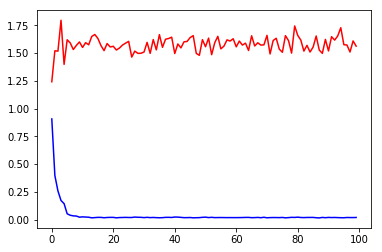

In [6]:
main()

In [4]:
# import argparse

class HParams(object):
	def __init__(self):
		# Dataset Settings
		self.dataset_path = 'd:/다운로드/gtzan'
		self.feature_path = 'feature'
		self.genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae']

		# Feature Parameters
		self.sample_rate = 22050
		self.fft_size = 1024
		self.win_size = 1024
		self.hop_size = 512
		self.num_mels = 128
		self.feature_length = 1024  # audio length = feature_length*hop_size/sample_rate (s)

		# Training Parameters
		self.device = 1  # 0: CPU, 1: GPU0, 2: GPU1, ...
		self.batch_size = 10
		self.num_epochs = 40
		self.learning_rate = 1e-5
		self.stopping_rate = 1e-12
		self.weight_decay = 1e-6
		self.momentum = 0.9
		self.factor = 0.2
		self.patience = 3.

hparams = HParams()
# hparams.parse_argument()

In [4]:
'''
CNN 계층 증가
Dropout 추가 1, 6
epoch : 100
batch : 10
'''
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        self._initialize_weights()
        
        # 128,32 kernel 8, strid 1 
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(8, stride=8)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(32, stride=32)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 117, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 117, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(117),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(117, 64, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        
#         self.block1 = nn.Sequential(
#         nn.Conv1d(256,128, kernel_size=8, stride=4, padding=3),
#         nn.BatchNorm1d(128),
#         nn.ReLU(),
#         nn.MaxPool1d(10, stride=10)
#         )
        
        
        self.conv4 = nn.Sequential(
        nn.Conv1d(128, 96, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(96),
        nn.ReLU(),
        nn.MaxPool1d(6, stride=6)
        )
        
        
        
        #self.fc0 = nn.Linear(3*96, 117)
        #torch.nn.init.xavier_uniform_(self.fc0.weight)
        
        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.3, inplace=False),
        nn.Linear(64*3, len(hparams.genres))
        )
        #self.linear1 = nn.Linear(117, len(hparams.genres))
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        #x1 = self.block0(x0)
        #x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = torch.cat((self.conv2_1(x),self.conv2_1(x)),2)
        #x = torch.cat((self.conv2_1(x),self.conv2_2(x)),2)
        x = self.conv3(x)
        #x = torch.cat((x,x,x),2)
        #x = x+x2#Resnet 2  
        #x = x*x2
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fand_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias,0)

Training on GPU:0
[Epoch 1/40] [Train Loss: 2.1165] [Train Acc: 0.1388] [Valid Loss: 2.0648] [Valid Acc: 0.1333]
[Epoch 2/40] [Train Loss: 2.0898] [Train Acc: 0.1453] [Valid Loss: 2.0561] [Valid Acc: 0.1467]
[Epoch 3/40] [Train Loss: 2.0632] [Train Acc: 0.1530] [Valid Loss: 2.0510] [Valid Acc: 0.1533]
[Epoch 4/40] [Train Loss: 2.0469] [Train Acc: 0.1680] [Valid Loss: 2.0473] [Valid Acc: 0.1467]
[Epoch 5/40] [Train Loss: 2.0260] [Train Acc: 0.1728] [Valid Loss: 2.0437] [Valid Acc: 0.2000]
[Epoch 6/40] [Train Loss: 2.0164] [Train Acc: 0.1929] [Valid Loss: 2.0389] [Valid Acc: 0.2667]
[Epoch 7/40] [Train Loss: 2.0076] [Train Acc: 0.2045] [Valid Loss: 2.0346] [Valid Acc: 0.2533]
[Epoch 8/40] [Train Loss: 1.9873] [Train Acc: 0.2144] [Valid Loss: 2.0289] [Valid Acc: 0.2467]
[Epoch 9/40] [Train Loss: 1.9749] [Train Acc: 0.2343] [Valid Loss: 2.0242] [Valid Acc: 0.2600]
[Epoch 10/40] [Train Loss: 1.9562] [Train Acc: 0.2470] [Valid Loss: 2.0197] [Valid Acc: 0.2533]
[Epoch 11/40] [Train Loss: 1.93

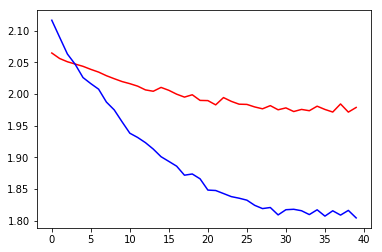

In [11]:
main()

Training on GPU:0
[Epoch 1/40] [Train Loss: 2.0227] [Train Acc: 0.2266] [Valid Loss: 2.0482] [Valid Acc: 0.2333]
[Epoch 2/40] [Train Loss: 1.9049] [Train Acc: 0.2943] [Valid Loss: 2.0046] [Valid Acc: 0.2200]
[Epoch 3/40] [Train Loss: 1.8115] [Train Acc: 0.3674] [Valid Loss: 1.9794] [Valid Acc: 0.1667]
[Epoch 4/40] [Train Loss: 1.7381] [Train Acc: 0.4028] [Valid Loss: 1.9580] [Valid Acc: 0.1733]
[Epoch 5/40] [Train Loss: 1.6848] [Train Acc: 0.4346] [Valid Loss: 1.9210] [Valid Acc: 0.2000]
[Epoch 6/40] [Train Loss: 1.6339] [Train Acc: 0.4700] [Valid Loss: 1.8973] [Valid Acc: 0.2400]
[Epoch 7/40] [Train Loss: 1.5797] [Train Acc: 0.5023] [Valid Loss: 1.8665] [Valid Acc: 0.2600]
[Epoch 8/40] [Train Loss: 1.5301] [Train Acc: 0.5354] [Valid Loss: 1.8685] [Valid Acc: 0.2600]
[Epoch 9/40] [Train Loss: 1.5040] [Train Acc: 0.5479] [Valid Loss: 1.8348] [Valid Acc: 0.2733]
[Epoch 10/40] [Train Loss: 1.4645] [Train Acc: 0.5779] [Valid Loss: 1.8058] [Valid Acc: 0.3133]
[Epoch 11/40] [Train Loss: 1.43

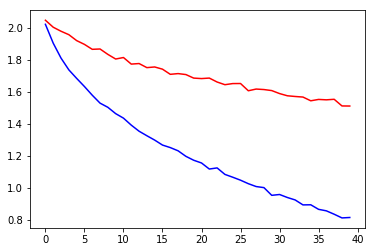

In [13]:
main()

In [23]:
# import argparse

class HParams(object):
    def __init__(self):
        # Dataset Settings
        self.dataset_path = 'd:/다운로드/gtzan'
        self.feature_path = 'feature'
        self.genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae']

        # Feature Parameters
        self.sample_rate = 22050
        self.fft_size = 1024
        self.win_size = 1024
        self.hop_size = 512
        self.num_mels = 128
        self.feature_length = 1024  # audio length = feature_length*hop_size/sample_rate (s)

        # Training Parameters
        self.device = 1  # 0: CPU, 1: GPU0, 2: GPU1, ...
        self.batch_size = 10
        self.num_epochs = 100
        self.learning_rate = 1e-1
        self.stopping_rate = 1e-12
        self.weight_decay = 1e-6
        self.momentum = 0.9
        self.factor = 0.2
        self.patience = 3.

hparams = HParams()
# hparams.parse_argument()

In [32]:
'''
CNN 계층 증가
Dropout 추가 1, 6
epoch : 100
batch : 10
'''
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        self._initialize_weights()
        
        # 128,32 kernel 8, strid 1 
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(8, stride=8)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(32, stride=32)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 117, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(117),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 117, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(117),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(117, 64, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        
#         self.block1 = nn.Sequential(
#         nn.Conv1d(256,128, kernel_size=8, stride=4, padding=3),
#         nn.BatchNorm1d(128),
#         nn.ReLU(),
#         nn.MaxPool1d(10, stride=10)
#         )
        
        
        self.conv4 = nn.Sequential(
        nn.Conv1d(64, 96, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(96),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.fc0 = nn.Linear(96, len(hparams.genres))
        torch.nn.init.xavier_uniform_(self.fc0.weight)
                             
#         self.linear0 = nn.Sequential(
#         nn.Dropout(p=0.3, inplace=False),
#         nn.Linear(96, len(hparams.genres))
#         )
#         torch.nn.init.xavier_uniform_(self.linear0.weight)
        #self.linear1 = nn.Linear(117, len(hparams.genres))

    def forward(self, x):

        x0 = x.transpose(1, 2)
        #x1 = self.block0(x0)
        #x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = torch.cat((self.conv2_1(x),self.conv2_1(x)),2)
        #x = torch.cat((self.conv2_1(x),self.conv2_2(x)),2)
        x = self.conv3(x)
        #x = torch.cat((x,x,x),2)
        #x = x+x2#Resnet 2  
        #x = x*x2
        x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.fc0(x)

        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fand_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias,0)

Training on GPU:0
[Epoch 1/100] [Train Loss: 1.6682] [Train Acc: 0.3856] [Valid Loss: 1.8093] [Valid Acc: 0.3067]
[Epoch 2/100] [Train Loss: 1.4435] [Train Acc: 0.4660] [Valid Loss: 1.4901] [Valid Acc: 0.5200]
[Epoch 3/100] [Train Loss: 1.2358] [Train Acc: 0.5802] [Valid Loss: 1.7375] [Valid Acc: 0.3933]
[Epoch 4/100] [Train Loss: 1.1262] [Train Acc: 0.6130] [Valid Loss: 1.6073] [Valid Acc: 0.4867]
[Epoch 5/100] [Train Loss: 1.0173] [Train Acc: 0.6680] [Valid Loss: 2.0816] [Valid Acc: 0.4867]
[Epoch 6/100] [Train Loss: 0.9521] [Train Acc: 0.6955] [Valid Loss: 1.6654] [Valid Acc: 0.4467]
Epoch     6: reducing learning rate of group 0 to 2.0000e-02.
[Epoch 7/100] [Train Loss: 0.5365] [Train Acc: 0.8246] [Valid Loss: 1.7289] [Valid Acc: 0.4933]
[Epoch 8/100] [Train Loss: 0.4836] [Train Acc: 0.8453] [Valid Loss: 1.5771] [Valid Acc: 0.5400]
[Epoch 9/100] [Train Loss: 0.4256] [Train Acc: 0.8660] [Valid Loss: 2.2606] [Valid Acc: 0.4933]
[Epoch 10/100] [Train Loss: 0.3804] [Train Acc: 0.8779] 

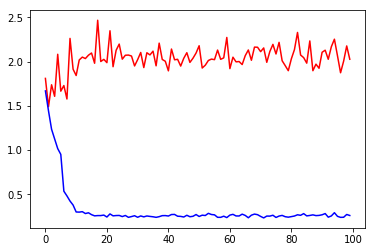

In [33]:
main()

In [34]:
# import argparse

class HParams(object):
    def __init__(self):
        # Dataset Settings
        self.dataset_path = 'd:/다운로드/gtzan'
        self.feature_path = 'feature'
        self.genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae']

        # Feature Parameters
        self.sample_rate = 22050
        self.fft_size = 1024
        self.win_size = 1024
        self.hop_size = 512
        self.num_mels = 128
        self.feature_length = 1024  # audio length = feature_length*hop_size/sample_rate (s)

        # Training Parameters
        self.device = 1  # 0: CPU, 1: GPU0, 2: GPU1, ...
        self.batch_size = 30
        self.num_epochs = 100
        self.learning_rate = 1e-1
        self.stopping_rate = 1e-12
        self.weight_decay = 1e-6
        self.momentum = 0.9
        self.factor = 0.2
        self.patience = 3.

hparams = HParams()
# hparams.parse_argument()

In [37]:
'''
CNN 계층 증가
Dropout 추가 1, 6
epoch : 100
batch : 10
'''
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        self._initialize_weights()
        
        # 128,32 kernel 8, strid 1 
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(32, stride=32)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 117, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(117),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 117, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(117),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(117, 64, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        
#         self.block1 = nn.Sequential(
#         nn.Conv1d(256,128, kernel_size=8, stride=4, padding=3),
#         nn.BatchNorm1d(128),
#         nn.ReLU(),
#         nn.MaxPool1d(10, stride=10)
#         )
        
        
        self.conv4 = nn.Sequential(
        nn.Conv1d(64, 96, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(96),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.fc0 = nn.Linear(96, len(hparams.genres))
        torch.nn.init.xavier_uniform_(self.fc0.weight)
                             
#         self.linear0 = nn.Sequential(
#         nn.Dropout(p=0.3, inplace=False),
#         nn.Linear(96, len(hparams.genres))
#         )
#         torch.nn.init.xavier_uniform_(self.linear0.weight)
        #self.linear1 = nn.Linear(117, len(hparams.genres))

    def forward(self, x):

        x0 = x.transpose(1, 2)
        #x1 = self.block0(x0)
        #x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = torch.cat((self.conv2_1(x),self.conv2_1(x)),2)
        #x = torch.cat((self.conv2_1(x),self.conv2_2(x)),2)
        x = self.conv3(x)
        #x = torch.cat((x,x,x),2)
        #x = x+x2#Resnet 2  
        #x = x*x2
        x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.fc0(x)

        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fand_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias,0)

Training on GPU:0
[Epoch 1/100] [Train Loss: 1.2460] [Train Acc: 0.5592] [Valid Loss: 1.5816] [Valid Acc: 0.4867]
[Epoch 2/100] [Train Loss: 0.7705] [Train Acc: 0.7473] [Valid Loss: 1.8867] [Valid Acc: 0.5533]
[Epoch 3/100] [Train Loss: 0.5380] [Train Acc: 0.8235] [Valid Loss: 1.5891] [Valid Acc: 0.5933]
[Epoch 4/100] [Train Loss: 0.4030] [Train Acc: 0.8751] [Valid Loss: 1.9397] [Valid Acc: 0.6333]
[Epoch 5/100] [Train Loss: 0.2982] [Train Acc: 0.9034] [Valid Loss: 1.9572] [Valid Acc: 0.5933]
Epoch     5: reducing learning rate of group 0 to 2.0000e-02.
[Epoch 6/100] [Train Loss: 0.1442] [Train Acc: 0.9550] [Valid Loss: 1.3211] [Valid Acc: 0.6733]
[Epoch 7/100] [Train Loss: 0.0923] [Train Acc: 0.9734] [Valid Loss: 1.3821] [Valid Acc: 0.6933]
[Epoch 8/100] [Train Loss: 0.0832] [Train Acc: 0.9759] [Valid Loss: 1.3962] [Valid Acc: 0.6867]
[Epoch 9/100] [Train Loss: 0.0747] [Train Acc: 0.9765] [Valid Loss: 1.5948] [Valid Acc: 0.6467]
[Epoch 10/100] [Train Loss: 0.0678] [Train Acc: 0.9788] 

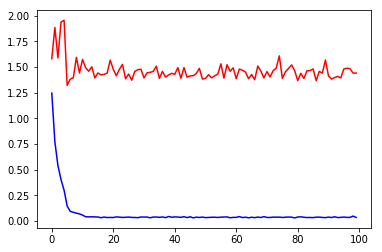

In [38]:
main()

In [61]:
# import argparse

class HParams(object):
    def __init__(self):
        # Dataset Settings
        self.dataset_path = 'd:/다운로드/gtzan'
        self.feature_path = 'feature'
        self.genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae']

        # Feature Parameters
        self.sample_rate = 22050
        self.fft_size = 1024
        self.win_size = 1024
        self.hop_size = 512
        self.num_mels = 128
        self.feature_length = 1024  # audio length = feature_length*hop_size/sample_rate (s)

        # Training Parameters
        self.device = 1  # 0: CPU, 1: GPU0, 2: GPU1, ...
        self.batch_size = 10
        self.num_epochs = 50
        self.learning_rate = 1e-3
        self.stopping_rate = 1e-12
        self.weight_decay = 1e-6
        self.momentum = 0.8
        self.factor = 0.2
        self.patience = 3.

hparams = HParams()
# hparams.parse_argument()

In [62]:
'''
CNN 계층 증가
Dropout 추가 1, 6
epoch : 100
batch : 10
'''
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
#         self._initialize_weights()
        
        # 128,32 kernel 8, strid 1 
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(32, stride=32)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 117, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(117),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 117, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(117),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(117, 64, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        
#         self.block1 = nn.Sequential(
#         nn.Conv1d(256,128, kernel_size=8, stride=4, padding=3),
#         nn.BatchNorm1d(128),
#         nn.ReLU(),
#         nn.MaxPool1d(10, stride=10)
#         )
        
        
        self.conv4 = nn.Sequential(
        nn.Conv1d(64, 96, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(96),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.fc0 = nn.Linear(96, len(hparams.genres))
        torch.nn.init.xavier_uniform_(self.fc0.weight)
                             
#         self.linear0 = nn.Sequential(
#         nn.Dropout(p=0.3, inplace=False),
#         nn.Linear(96, len(hparams.genres))
#         )
#         torch.nn.init.xavier_uniform_(self.linear0.weight)
        #self.linear1 = nn.Linear(117, len(hparams.genres))

    def forward(self, x):

        x0 = x.transpose(1, 2)
        #x1 = self.block0(x0)
        #x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = torch.cat((self.conv2_1(x),self.conv2_1(x)),2)
        #x = torch.cat((self.conv2_1(x),self.conv2_2(x)),2)
        x = self.conv3(x)
        #x = torch.cat((x,x,x),2)
        #x = x+x2#Resnet 2  
        #x = x*x2
        x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.fc0(x)

        return x
    
#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv1d):
#                 nn.init.kaiming_normal_(m.weight, mode='fand_out', nonlinearity='relu')
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias,0)
#                 elif isinstance(m, nn.BatchNorm1d):
#                     nn.init.constant_(m.weight, 1)
#                     nn.init.constant_(m.bias, 0)
#                 elif isinstance(m, nn.Linear):
#                     nn.init.normal_(m.weight, 0, 0.01)
#                     nn.init.constant_(m.bias,0)

In [63]:
main()

MemoryError: 

In [14]:
'''
CNN 계층 증가
Dropout 추가 1, 6
epoch : 100
batch : 10
'''
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
#         self._initialize_weights()
        
        # 128,32 kernel 8, strid 1 
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        
        )

        #분할하여 다르게 처리
        self.conv2 = nn.Sequential(
        nn.Conv1d(128, 117, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(117),
        nn.Dropout(p=0.4, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
    

        self.fc0 = nn.Linear(117*6, len(hparams.genres))
        torch.nn.init.xavier_uniform_(self.fc0.weight)
                             
#         self.linear0 = nn.Sequential(
#         nn.Dropout(p=0.3, inplace=False),
#         nn.Linear(96, len(hparams.genres))
#         )
#         torch.nn.init.xavier_uniform_(self.linear0.weight)
        #self.linear1 = nn.Linear(117, len(hparams.genres))

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.fc0(x)

        return x
    
#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv1d):
#                 nn.init.kaiming_normal_(m.weight, mode='fand_out', nonlinearity='relu')
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias,0)
#                 elif isinstance(m, nn.BatchNorm1d):
#                     nn.init.constant_(m.weight, 1)
#                     nn.init.constant_(m.bias, 0)
#                 elif isinstance(m, nn.Linear):
#                     nn.init.normal_(m.weight, 0, 0.01)
#                     nn.init.constant_(m.bias,0)

In [40]:
# import argparse

class HParams(object):
    def __init__(self):
        # Dataset Settings
        self.dataset_path = 'd:/다운로드/gtzan'
        self.feature_path = 'feature'
        self.genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae']

        # Feature Parameters
        self.sample_rate = 22050
        self.fft_size = 1024
        self.win_size = 1024
        self.hop_size = 512
        self.num_mels = 128
        self.feature_length = 1024  # audio length = feature_length*hop_size/sample_rate (s)

        # Training Parameters
        self.device = 1  # 0: CPU, 1: GPU0, 2: GPU1, ...
        self.batch_size = 20
        self.num_epochs = 100
        self.learning_rate = 1e-6
        self.stopping_rate = 1e-12
        self.weight_decay = 1e-6
        self.momentum = 0.8
        self.factor = 0.2
        self.patience = 3.

hparams = HParams()
# hparams.parse_argument()

Training on GPU:0
[Epoch 1/40] [Train Loss: 1.7834] [Train Acc: 0.3510] [Valid Loss: 1.5992] [Valid Acc: 0.4733]
[Epoch 2/40] [Train Loss: 1.2764] [Train Acc: 0.5691] [Valid Loss: 1.4615] [Valid Acc: 0.4933]
[Epoch 3/40] [Train Loss: 1.0699] [Train Acc: 0.6510] [Valid Loss: 1.3984] [Valid Acc: 0.5000]
[Epoch 4/40] [Train Loss: 0.9314] [Train Acc: 0.7215] [Valid Loss: 1.3626] [Valid Acc: 0.5067]
[Epoch 5/40] [Train Loss: 0.8323] [Train Acc: 0.7524] [Valid Loss: 1.3416] [Valid Acc: 0.5400]
[Epoch 6/40] [Train Loss: 0.7500] [Train Acc: 0.7867] [Valid Loss: 1.3151] [Valid Acc: 0.5400]
[Epoch 7/40] [Train Loss: 0.6975] [Train Acc: 0.8108] [Valid Loss: 1.2859] [Valid Acc: 0.5667]
[Epoch 8/40] [Train Loss: 0.6553] [Train Acc: 0.8210] [Valid Loss: 1.2756] [Valid Acc: 0.5467]
[Epoch 9/40] [Train Loss: 0.5985] [Train Acc: 0.8487] [Valid Loss: 1.2631] [Valid Acc: 0.5467]
[Epoch 10/40] [Train Loss: 0.5599] [Train Acc: 0.8601] [Valid Loss: 1.2633] [Valid Acc: 0.5733]
[Epoch 11/40] [Train Loss: 0.53

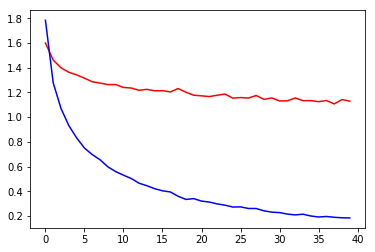

In [15]:
main()

Training on GPU:0
[Epoch 1/50] [Train Loss: 2.2297] [Train Acc: 0.2195] [Valid Loss: 1.9703] [Valid Acc: 0.3533]
[Epoch 2/50] [Train Loss: 1.8190] [Train Acc: 0.3671] [Valid Loss: 1.8260] [Valid Acc: 0.3933]
[Epoch 3/50] [Train Loss: 1.6163] [Train Acc: 0.4380] [Valid Loss: 1.7242] [Valid Acc: 0.4533]
[Epoch 4/50] [Train Loss: 1.4573] [Train Acc: 0.5028] [Valid Loss: 1.6520] [Valid Acc: 0.4867]
[Epoch 5/50] [Train Loss: 1.3559] [Train Acc: 0.5419] [Valid Loss: 1.6076] [Valid Acc: 0.4933]
[Epoch 6/50] [Train Loss: 1.2738] [Train Acc: 0.5833] [Valid Loss: 1.5677] [Valid Acc: 0.5000]
[Epoch 7/50] [Train Loss: 1.2141] [Train Acc: 0.6037] [Valid Loss: 1.5363] [Valid Acc: 0.5600]
[Epoch 8/50] [Train Loss: 1.1460] [Train Acc: 0.6399] [Valid Loss: 1.5011] [Valid Acc: 0.5733]
[Epoch 9/50] [Train Loss: 1.0926] [Train Acc: 0.6561] [Valid Loss: 1.4803] [Valid Acc: 0.5667]
[Epoch 10/50] [Train Loss: 1.0387] [Train Acc: 0.6759] [Valid Loss: 1.4556] [Valid Acc: 0.5867]
[Epoch 11/50] [Train Loss: 0.99

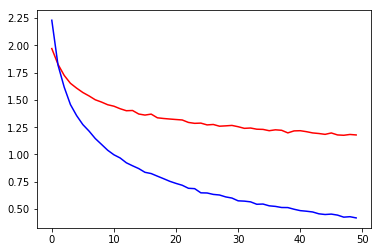

In [17]:
main()

Training on GPU:0
[Epoch 1/100] [Train Loss: 2.3667] [Train Acc: 0.1499] [Valid Loss: 2.1724] [Valid Acc: 0.1400]
[Epoch 2/100] [Train Loss: 2.2299] [Train Acc: 0.1643] [Valid Loss: 2.0860] [Valid Acc: 0.1733]
[Epoch 3/100] [Train Loss: 2.1109] [Train Acc: 0.2006] [Valid Loss: 2.0107] [Valid Acc: 0.1933]
[Epoch 4/100] [Train Loss: 2.0360] [Train Acc: 0.2507] [Valid Loss: 1.9475] [Valid Acc: 0.2333]
[Epoch 5/100] [Train Loss: 1.9531] [Train Acc: 0.2816] [Valid Loss: 1.9081] [Valid Acc: 0.2800]
[Epoch 6/100] [Train Loss: 1.8995] [Train Acc: 0.3020] [Valid Loss: 1.8759] [Valid Acc: 0.3000]
[Epoch 7/100] [Train Loss: 1.8510] [Train Acc: 0.3201] [Valid Loss: 1.8422] [Valid Acc: 0.3267]
[Epoch 8/100] [Train Loss: 1.8058] [Train Acc: 0.3272] [Valid Loss: 1.8245] [Valid Acc: 0.3400]
[Epoch 9/100] [Train Loss: 1.7884] [Train Acc: 0.3431] [Valid Loss: 1.8104] [Valid Acc: 0.3400]
[Epoch 10/100] [Train Loss: 1.7483] [Train Acc: 0.3589] [Valid Loss: 1.7841] [Valid Acc: 0.3667]
[Epoch 11/100] [Train

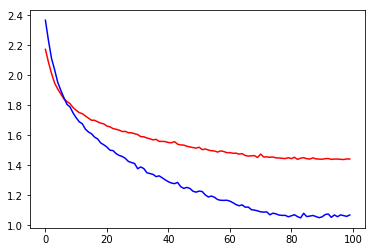

In [21]:
main()

In [9]:
'''
CNN 계층 증가
Dropout 추가 1, 6
epoch : 100
batch : 10
'''
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        #self._initialize_weights()
        
        # 128,32 kernel 8, strid 1 
        self.conv0 = nn.Conv1d(hparams.num_mels, 256, kernel_size=8, stride=1, padding=1)
        self.lay0 = nn.Sequential(
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        self.conv1 = nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=1)
        self.lay1 = nn.Sequential(
        nn.BatchNorm1d(128),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(8, stride=8)
        )

        #분할하여 다르게 처리
        self.conv2 =nn.Conv1d(128, 117, kernel_size=8, stride=1, padding=1)
        self.lay2_1 = nn.Sequential(
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        self.lay2_2 = nn.Sequential(
        nn.BatchNorm1d(117),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        self.conv3=nn.Conv1d(117, 64, kernel_size=4, stride=1, padding=2)
        self.lay3 = nn.Sequential(
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        
        
        self.fc0 = nn.Linear(64*3, len(hparams.genres))
        torch.nn.init.xavier_uniform_(self.fc0.weight)
        
#         self.linear0 = nn.Sequential(
#         nn.Linear(64*3, len(hparams.genres))
#         )
        #self.linear1 = nn.Linear(117, len(hparams.genres))
        
        nn.init.xavier_uniform_(self.conv0.weight)
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.conv3.weight)
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x = self.conv0(x0)
        x = self.lay0(x)
        x = self.conv1(x)
        x = self.lay1(x)
        x = self.conv2(x)
        x = torch.cat((self.lay2_1(x),self.lay2_2(x)),2)
        x = self.conv3(x)
        x = self.lay3(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.fc0(x)

        return x
    
#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv1d):
#                 nn.init.kaiming_normal_(m.weight, mode='fand_out', nonlinearity='relu')
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias,1)
#                 elif isinstance(m, nn.BatchNorm1d):
#                     nn.init.constant_(m.weight, 1)
#                     nn.init.constant_(m.bias, 1)
#                 elif isinstance(m, nn.Linear):
#                     nn.init.normal_(m.weight, 0, 0.01)
#                     nn.init.constant_(m.bias,1)

Training on GPU:0
[Epoch 1/100] [Train Loss: 2.1079] [Train Acc: 0.1150] [Valid Loss: 2.1026] [Valid Acc: 0.1067]
[Epoch 2/100] [Train Loss: 2.0986] [Train Acc: 0.1130] [Valid Loss: 2.1001] [Valid Acc: 0.1133]
[Epoch 3/100] [Train Loss: 2.0898] [Train Acc: 0.1210] [Valid Loss: 2.0949] [Valid Acc: 0.1133]
[Epoch 4/100] [Train Loss: 2.0807] [Train Acc: 0.1207] [Valid Loss: 2.0907] [Valid Acc: 0.1333]
[Epoch 5/100] [Train Loss: 2.0739] [Train Acc: 0.1127] [Valid Loss: 2.0871] [Valid Acc: 0.1267]
[Epoch 6/100] [Train Loss: 2.0647] [Train Acc: 0.1218] [Valid Loss: 2.0822] [Valid Acc: 0.1467]
[Epoch 7/100] [Train Loss: 2.0507] [Train Acc: 0.1314] [Valid Loss: 2.0787] [Valid Acc: 0.1467]
[Epoch 8/100] [Train Loss: 2.0502] [Train Acc: 0.1351] [Valid Loss: 2.0761] [Valid Acc: 0.1667]
[Epoch 9/100] [Train Loss: 2.0450] [Train Acc: 0.1334] [Valid Loss: 2.0734] [Valid Acc: 0.1533]
[Epoch 10/100] [Train Loss: 2.0327] [Train Acc: 0.1428] [Valid Loss: 2.0687] [Valid Acc: 0.1667]
[Epoch 11/100] [Train

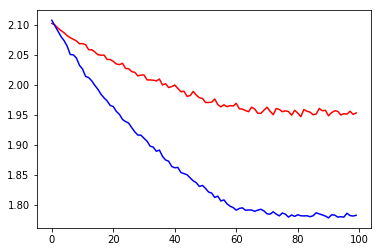

In [23]:
main()

Training on GPU:0
[Epoch 1/100] [Train Loss: 2.0706] [Train Acc: 0.1317] [Valid Loss: 2.0513] [Valid Acc: 0.1867]
[Epoch 2/100] [Train Loss: 1.9934] [Train Acc: 0.1912] [Valid Loss: 2.0075] [Valid Acc: 0.2600]
[Epoch 3/100] [Train Loss: 1.9365] [Train Acc: 0.2533] [Valid Loss: 1.9799] [Valid Acc: 0.2800]
[Epoch 4/100] [Train Loss: 1.8803] [Train Acc: 0.3059] [Valid Loss: 1.9543] [Valid Acc: 0.2667]
[Epoch 5/100] [Train Loss: 1.8368] [Train Acc: 0.3527] [Valid Loss: 1.9416] [Valid Acc: 0.2867]
[Epoch 6/100] [Train Loss: 1.8021] [Train Acc: 0.3938] [Valid Loss: 1.9232] [Valid Acc: 0.2933]
[Epoch 7/100] [Train Loss: 1.7647] [Train Acc: 0.4272] [Valid Loss: 1.9095] [Valid Acc: 0.3000]
[Epoch 8/100] [Train Loss: 1.7328] [Train Acc: 0.4521] [Valid Loss: 1.8887] [Valid Acc: 0.3400]
[Epoch 9/100] [Train Loss: 1.6994] [Train Acc: 0.4779] [Valid Loss: 1.8720] [Valid Acc: 0.3800]
[Epoch 10/100] [Train Loss: 1.6744] [Train Acc: 0.4955] [Valid Loss: 1.8578] [Valid Acc: 0.3800]
[Epoch 11/100] [Train

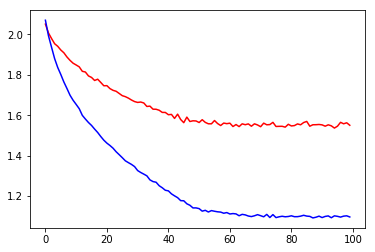

In [27]:
main()

In [11]:
# import argparse

class HParams(object):
    def __init__(self):
        # Dataset Settings
        self.dataset_path = 'd:/다운로드/gtzan'
        self.feature_path = 'feature'
        self.genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae']

        # Feature Parameters
        self.sample_rate = 22050
        self.fft_size = 1024
        self.win_size = 1024
        self.hop_size = 512
        self.num_mels = 128
        self.feature_length = 1024  # audio length = feature_length*hop_size/sample_rate (s)

        # Training Parameters
        self.device = 1  # 0: CPU, 1: GPU0, 2: GPU1, ...
        self.batch_size = 20
        self.num_epochs = 100
        self.learning_rate = 1e-5
        self.stopping_rate = 1e-12
        self.weight_decay = 1e-6
        self.momentum = 0.8
        self.factor = 0.2
        self.patience = 3.

hparams = HParams()
# hparams.parse_argument()

Training on GPU:0
[Epoch 1/100] [Train Loss: 1.9232] [Train Acc: 0.3142] [Valid Loss: 1.8963] [Valid Acc: 0.3133]
[Epoch 2/100] [Train Loss: 1.6375] [Train Acc: 0.4742] [Valid Loss: 1.7597] [Valid Acc: 0.3667]
[Epoch 3/100] [Train Loss: 1.4704] [Train Acc: 0.5909] [Valid Loss: 1.6798] [Valid Acc: 0.3600]
[Epoch 4/100] [Train Loss: 1.3445] [Train Acc: 0.6669] [Valid Loss: 1.6030] [Valid Acc: 0.4000]
[Epoch 5/100] [Train Loss: 1.2571] [Train Acc: 0.7025] [Valid Loss: 1.5485] [Valid Acc: 0.4400]
[Epoch 6/100] [Train Loss: 1.1678] [Train Acc: 0.7416] [Valid Loss: 1.5142] [Valid Acc: 0.4600]
[Epoch 7/100] [Train Loss: 1.1005] [Train Acc: 0.7572] [Valid Loss: 1.4978] [Valid Acc: 0.4267]
[Epoch 8/100] [Train Loss: 1.0230] [Train Acc: 0.7878] [Valid Loss: 1.4703] [Valid Acc: 0.4267]
[Epoch 9/100] [Train Loss: 0.9635] [Train Acc: 0.8108] [Valid Loss: 1.4371] [Valid Acc: 0.4667]
[Epoch 10/100] [Train Loss: 0.9048] [Train Acc: 0.8244] [Valid Loss: 1.4080] [Valid Acc: 0.5133]
[Epoch 11/100] [Train

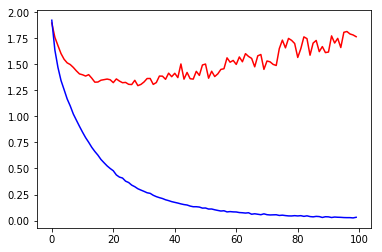

In [30]:
main()

Training on GPU:0
[Epoch 1/100] [Train Loss: 1.7966] [Train Acc: 0.3796] [Valid Loss: 1.8022] [Valid Acc: 0.3800]
[Epoch 2/100] [Train Loss: 1.5089] [Train Acc: 0.5779] [Valid Loss: 1.6905] [Valid Acc: 0.4400]
[Epoch 3/100] [Train Loss: 1.3517] [Train Acc: 0.6513] [Valid Loss: 1.6150] [Valid Acc: 0.4533]
[Epoch 4/100] [Train Loss: 1.2370] [Train Acc: 0.6952] [Valid Loss: 1.5638] [Valid Acc: 0.4800]
[Epoch 5/100] [Train Loss: 1.1415] [Train Acc: 0.7306] [Valid Loss: 1.5309] [Valid Acc: 0.4800]
[Epoch 6/100] [Train Loss: 1.0710] [Train Acc: 0.7473] [Valid Loss: 1.5263] [Valid Acc: 0.4467]
[Epoch 7/100] [Train Loss: 1.0023] [Train Acc: 0.7827] [Valid Loss: 1.4869] [Valid Acc: 0.4600]
[Epoch 8/100] [Train Loss: 0.9378] [Train Acc: 0.8065] [Valid Loss: 1.4693] [Valid Acc: 0.4667]
[Epoch 9/100] [Train Loss: 0.8697] [Train Acc: 0.8283] [Valid Loss: 1.4457] [Valid Acc: 0.5067]
[Epoch 10/100] [Train Loss: 0.8183] [Train Acc: 0.8385] [Valid Loss: 1.4488] [Valid Acc: 0.5000]
[Epoch 11/100] [Train

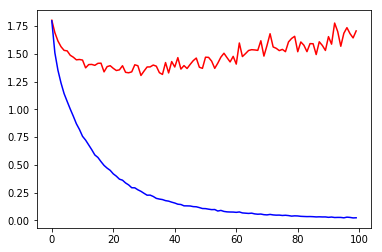

In [32]:
main()

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.7384] [Train Acc: 0.3983] [Valid Loss: 1.8921] [Valid Acc: 0.2800]
[Epoch 20/100] [Train Loss: 1.5200] [Train Acc: 0.5261] [Valid Loss: 1.7442] [Valid Acc: 0.3600]
[Epoch 30/100] [Train Loss: 1.3640] [Train Acc: 0.5858] [Valid Loss: 1.6252] [Valid Acc: 0.4333]
[Epoch 40/100] [Train Loss: 1.2480] [Train Acc: 0.6286] [Valid Loss: 1.5566] [Valid Acc: 0.4667]
[Epoch 50/100] [Train Loss: 1.1559] [Train Acc: 0.6694] [Valid Loss: 1.5030] [Valid Acc: 0.5067]
[Epoch 60/100] [Train Loss: 1.0753] [Train Acc: 0.6892] [Valid Loss: 1.4533] [Valid Acc: 0.5000]
[Epoch 70/100] [Train Loss: 1.0155] [Train Acc: 0.7187] [Valid Loss: 1.4190] [Valid Acc: 0.5133]
[Epoch 80/100] [Train Loss: 0.9604] [Train Acc: 0.7363] [Valid Loss: 1.4002] [Valid Acc: 0.5600]
[Epoch 90/100] [Train Loss: 0.9041] [Train Acc: 0.7569] [Valid Loss: 1.3503] [Valid Acc: 0.5800]
[Epoch 100/100] [Train Loss: 0.8590] [Train Acc: 0.7683] [Valid Loss: 1.3506] [Valid Acc: 0.5600]
Training Fi

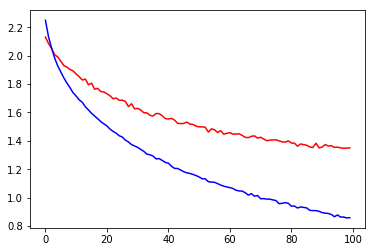

In [12]:
main()

In [15]:
'''
CNN 계층 증가
Dropout 추가 1, 6
epoch : 100
batch : 10
'''
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        self._initialize_weights()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        
        
        self.conv4 = nn.Sequential(
        nn.Conv1d(128, 96, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(96),
        nn.ReLU(),
        nn.MaxPool1d(6, stride=6)
        )

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(96, 117),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)+x1 #Resnet1
        x = torch.cat((self.conv2_1(x)+self.conv2_2(x),self.conv2_2(x)+self.conv2_1(x)),2)
        x = self.conv3(x)
        x = x+x2#Resnet 2  
        #x = x*x2
        x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fand_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0.8)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0.8)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias,0.8)

Training on GPU:0
[Epoch 10/100] [Train Loss: 2.0337] [Train Acc: 0.2079] [Valid Loss: 2.0525] [Valid Acc: 0.2533]
[Epoch 20/100] [Train Loss: 1.9926] [Train Acc: 0.2722] [Valid Loss: 2.0189] [Valid Acc: 0.2667]
[Epoch 30/100] [Train Loss: 1.9532] [Train Acc: 0.3416] [Valid Loss: 1.9880] [Valid Acc: 0.3733]
[Epoch 40/100] [Train Loss: 1.9234] [Train Acc: 0.3816] [Valid Loss: 1.9631] [Valid Acc: 0.3733]
[Epoch 50/100] [Train Loss: 1.8871] [Train Acc: 0.4337] [Valid Loss: 1.9302] [Valid Acc: 0.3933]
[Epoch 60/100] [Train Loss: 1.8548] [Train Acc: 0.4487] [Valid Loss: 1.9059] [Valid Acc: 0.3600]
[Epoch 70/100] [Train Loss: 1.8212] [Train Acc: 0.4637] [Valid Loss: 1.8697] [Valid Acc: 0.3867]
[Epoch 80/100] [Train Loss: 1.7843] [Train Acc: 0.4912] [Valid Loss: 1.8423] [Valid Acc: 0.3467]
[Epoch 90/100] [Train Loss: 1.7508] [Train Acc: 0.5023] [Valid Loss: 1.8170] [Valid Acc: 0.3533]
[Epoch 100/100] [Train Loss: 1.7182] [Train Acc: 0.5170] [Valid Loss: 1.7882] [Valid Acc: 0.3600]
Training Fi

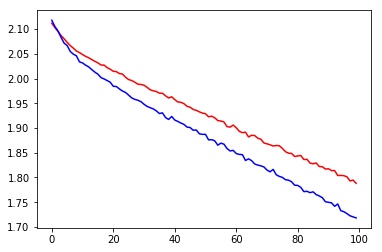

In [14]:
main()

In [20]:
# import argparse

class HParams(object):
    def __init__(self):
        # Dataset Settings
        self.dataset_path = 'd:/다운로드/gtzan'
        self.feature_path = 'feature'
        self.genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae']

        # Feature Parameters
        self.sample_rate = 22050
        self.fft_size = 1024
        self.win_size = 1024
        self.hop_size = 512
        self.num_mels = 128
        self.feature_length = 1024  # audio length = feature_length*hop_size/sample_rate (s)

        # Training Parameters
        self.device = 1  # 0: CPU, 1: GPU0, 2: GPU1, ...
        self.batch_size = 5
        self.num_epochs = 100
        self.learning_rate = 1e-6
        self.stopping_rate = 1e-10
        self.weight_decay = 1e-6
        self.momentum = 0.8
        self.factor = 0.2
        self.patience = 3.

hparams = HParams()
# hparams.parse_argument()

Training on GPU:0
[Epoch 10/100] [Train Loss: 2.0747] [Train Acc: 0.1584] [Valid Loss: 2.0585] [Valid Acc: 0.1467]
[Epoch 20/100] [Train Loss: 2.0583] [Train Acc: 0.1918] [Valid Loss: 2.0398] [Valid Acc: 0.2067]
[Epoch 30/100] [Train Loss: 2.0418] [Train Acc: 0.2229] [Valid Loss: 2.0226] [Valid Acc: 0.2400]
[Epoch 40/100] [Train Loss: 2.0201] [Train Acc: 0.2521] [Valid Loss: 2.0156] [Valid Acc: 0.2267]
[Epoch 50/100] [Train Loss: 2.0056] [Train Acc: 0.2745] [Valid Loss: 1.9958] [Valid Acc: 0.3000]
Epoch    56: reducing learning rate of group 0 to 2.0000e-07.
[Epoch 60/100] [Train Loss: 2.0003] [Train Acc: 0.2799] [Valid Loss: 1.9877] [Valid Acc: 0.2933]
[Epoch 70/100] [Train Loss: 1.9922] [Train Acc: 0.2986] [Valid Loss: 1.9888] [Valid Acc: 0.2733]
Epoch    73: reducing learning rate of group 0 to 4.0000e-08.
Epoch    78: reducing learning rate of group 0 to 8.0000e-09.
[Epoch 80/100] [Train Loss: 1.9917] [Train Acc: 0.2949] [Valid Loss: 1.9786] [Valid Acc: 0.3067]
[Epoch 90/100] [Trai

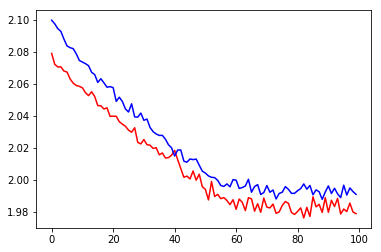

In [21]:
main()

In [7]:
'''
CNN 계층 증가
Dropout 추가 1, 6
epoch : 100
batch : 10
'''
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        
        
        self.conv4 = nn.Sequential(
        nn.Conv1d(128, 96, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(96),
        nn.ReLU(),
        nn.MaxPool1d(3, stride=3)
        )

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(96, 117),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)+x1 #Resnet1
        x = self.conv2_1(x)+self.conv2_2(x)
        x = self.conv3(x)
        x = x+x2#Resnet 2  
        x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

In [8]:
# import argparse

class HParams(object):
    def __init__(self):
        # Dataset Settings
        self.dataset_path = 'd:/다운로드/gtzan'
        self.feature_path = 'feature'
        self.genres = ['classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae']

        # Feature Parameters
        self.sample_rate = 22050
        self.fft_size = 1024
        self.win_size = 1024
        self.hop_size = 512
        self.num_mels = 128
        self.feature_length = 1024  # audio length = feature_length*hop_size/sample_rate (s)

        # Training Parameters
        self.device = 1  # 0: CPU, 1: GPU0, 2: GPU1, ...
        self.batch_size = 8
        self.num_epochs = 100
        self.learning_rate = 5*1e-5
        self.stopping_rate = 1e-10
        self.weight_decay = 1e-6
        self.momentum = 0.8
        self.factor = 0.2
        self.patience = 3.

hparams = HParams()

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.0879] [Train Acc: 0.6820] [Valid Loss: 1.3026] [Valid Acc: 0.4600]
[Epoch 20/100] [Train Loss: 0.4710] [Train Acc: 0.8870] [Valid Loss: 1.2824] [Valid Acc: 0.5333]
Epoch    23: reducing learning rate of group 0 to 1.0000e-05.
[Epoch 30/100] [Train Loss: 0.3072] [Train Acc: 0.9284] [Valid Loss: 1.2265] [Valid Acc: 0.5267]
Epoch    32: reducing learning rate of group 0 to 2.0000e-06.
Epoch    36: reducing learning rate of group 0 to 4.0000e-07.
[Epoch 40/100] [Train Loss: 0.2907] [Train Acc: 0.9364] [Valid Loss: 1.3377] [Valid Acc: 0.5200]
Epoch    40: reducing learning rate of group 0 to 8.0000e-08.
Epoch    44: reducing learning rate of group 0 to 1.6000e-08.
Epoch    48: reducing learning rate of group 0 to 3.2000e-09.
[Epoch 50/100] [Train Loss: 0.2892] [Train Acc: 0.9380] [Valid Loss: 1.2497] [Valid Acc: 0.5467]
[Epoch 60/100] [Train Loss: 0.2772] [Train Acc: 0.9405] [Valid Loss: 1.2051] [Valid Acc: 0.5600]
[Epoch 70/100] [Train Loss: 

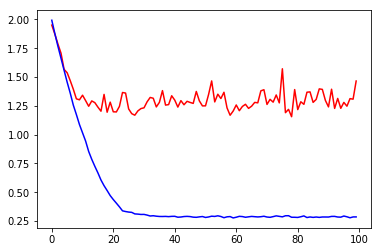

In [9]:
main()

In [10]:
hparams.learning_rate = 3*1e-5
hparams.momentum = 0.9

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.9907] [Train Acc: 0.7338] [Valid Loss: 1.1708] [Valid Acc: 0.5600]
[Epoch 20/100] [Train Loss: 0.3763] [Train Acc: 0.9106] [Valid Loss: 0.9786] [Valid Acc: 0.6333]
Epoch    29: reducing learning rate of group 0 to 6.0000e-06.
[Epoch 30/100] [Train Loss: 0.1818] [Train Acc: 0.9584] [Valid Loss: 0.9973] [Valid Acc: 0.6333]
Epoch    33: reducing learning rate of group 0 to 1.2000e-06.
Epoch    38: reducing learning rate of group 0 to 2.4000e-07.
[Epoch 40/100] [Train Loss: 0.1598] [Train Acc: 0.9669] [Valid Loss: 1.0200] [Valid Acc: 0.6333]
Epoch    42: reducing learning rate of group 0 to 4.8000e-08.
Epoch    46: reducing learning rate of group 0 to 9.6000e-09.
[Epoch 50/100] [Train Loss: 0.1591] [Train Acc: 0.9686] [Valid Loss: 0.9704] [Valid Acc: 0.6333]
[Epoch 60/100] [Train Loss: 0.1581] [Train Acc: 0.9666] [Valid Loss: 1.0726] [Valid Acc: 0.6133]
[Epoch 70/100] [Train Loss: 0.1566] [Train Acc: 0.9678] [Valid Loss: 0.9156] [Valid Acc: 0

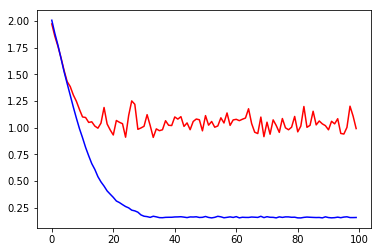

In [11]:
main()

In [12]:
hparams.learning_rate = 5*1e-5
hparams.momentum = 0.9
hparams.factor = 0.5
hparams.weight_decay = 1e-6

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.5166] [Train Acc: 0.8778] [Valid Loss: 1.0258] [Valid Acc: 0.6067]
Epoch    16: reducing learning rate of group 0 to 2.5000e-05.
[Epoch 20/100] [Train Loss: 0.1771] [Train Acc: 0.9624] [Valid Loss: 1.1621] [Valid Acc: 0.5933]
Epoch    20: reducing learning rate of group 0 to 1.2500e-05.
Epoch    24: reducing learning rate of group 0 to 6.2500e-06.
Epoch    28: reducing learning rate of group 0 to 3.1250e-06.
[Epoch 30/100] [Train Loss: 0.1369] [Train Acc: 0.9731] [Valid Loss: 1.1782] [Valid Acc: 0.6133]
Epoch    32: reducing learning rate of group 0 to 1.5625e-06.
Epoch    36: reducing learning rate of group 0 to 7.8125e-07.
[Epoch 40/100] [Train Loss: 0.1302] [Train Acc: 0.9727] [Valid Loss: 1.2881] [Valid Acc: 0.5467]
Epoch    40: reducing learning rate of group 0 to 3.9063e-07.
Epoch    44: reducing learning rate of group 0 to 1.9531e-07.
Epoch    48: reducing learning rate of group 0 to 9.7656e-08.
[Epoch 50/100] [Train Loss: 0.1252] 

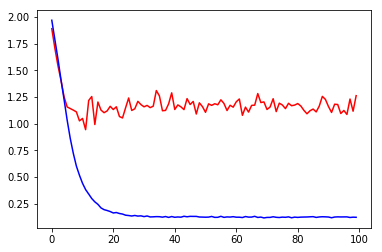

In [13]:
main()

In [14]:
hparams.num_epochs = 100
hparams.batch_size = 6
hparams.learning_rate = 5*1e-5
hparams.momentum = 0.8
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.8988] [Train Acc: 0.7646] [Valid Loss: 1.0972] [Valid Acc: 0.6467]
[Epoch 20/100] [Train Loss: 0.3570] [Train Acc: 0.9121] [Valid Loss: 0.9087] [Valid Acc: 0.6600]
Epoch    22: reducing learning rate of group 0 to 1.0000e-05.
Epoch    27: reducing learning rate of group 0 to 2.0000e-06.
[Epoch 30/100] [Train Loss: 0.2392] [Train Acc: 0.9449] [Valid Loss: 0.9428] [Valid Acc: 0.6533]
Epoch    31: reducing learning rate of group 0 to 4.0000e-07.
Epoch    35: reducing learning rate of group 0 to 8.0000e-08.
Epoch    39: reducing learning rate of group 0 to 1.6000e-08.
[Epoch 40/100] [Train Loss: 0.2401] [Train Acc: 0.9451] [Valid Loss: 0.9408] [Valid Acc: 0.6333]
Epoch    43: reducing learning rate of group 0 to 3.2000e-09.
[Epoch 50/100] [Train Loss: 0.2406] [Train Acc: 0.9443] [Valid Loss: 0.8887] [Valid Acc: 0.6667]
[Epoch 60/100] [Train Loss: 0.2397] [Train Acc: 0.9430] [Valid Loss: 0.9728] [Valid Acc: 0.6333]
[Epoch 70/100] [Train Loss: 

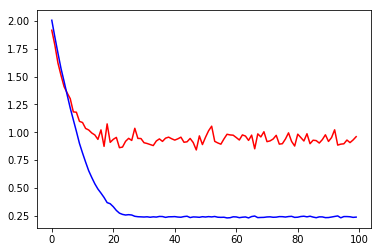

In [15]:
main()

In [16]:
hparams.num_epochs = 100
hparams.batch_size = 10
hparams.learning_rate = 7*1e-5
hparams.momentum = 0.8
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.9583] [Train Acc: 0.7541] [Valid Loss: 1.1550] [Valid Acc: 0.6133]
[Epoch 20/100] [Train Loss: 0.3423] [Train Acc: 0.9232] [Valid Loss: 0.9752] [Valid Acc: 0.6267]
Epoch    20: reducing learning rate of group 0 to 1.4000e-05.
Epoch    24: reducing learning rate of group 0 to 2.8000e-06.
Epoch    28: reducing learning rate of group 0 to 5.6000e-07.
[Epoch 30/100] [Train Loss: 0.2906] [Train Acc: 0.9358] [Valid Loss: 1.0506] [Valid Acc: 0.6200]
Epoch    32: reducing learning rate of group 0 to 1.1200e-07.
Epoch    36: reducing learning rate of group 0 to 2.2400e-08.
[Epoch 40/100] [Train Loss: 0.2872] [Train Acc: 0.9374] [Valid Loss: 1.0536] [Valid Acc: 0.6067]
Epoch    40: reducing learning rate of group 0 to 4.4800e-09.
[Epoch 50/100] [Train Loss: 0.2810] [Train Acc: 0.9416] [Valid Loss: 0.9825] [Valid Acc: 0.6467]
[Epoch 60/100] [Train Loss: 0.2823] [Train Acc: 0.9381] [Valid Loss: 0.9878] [Valid Acc: 0.6200]
[Epoch 70/100] [Train Loss: 

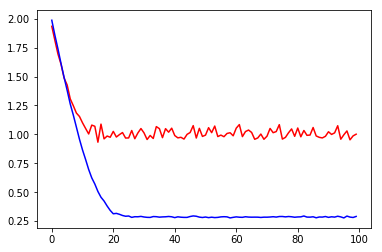

In [17]:
main()

In [18]:
hparams.num_epochs = 100
hparams.batch_size = 20
hparams.learning_rate = 8*1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.6989] [Train Acc: 0.8331] [Valid Loss: 1.1286] [Valid Acc: 0.6533]
Epoch    17: reducing learning rate of group 0 to 1.6000e-05.
[Epoch 20/100] [Train Loss: 0.2386] [Train Acc: 0.9555] [Valid Loss: 1.0938] [Valid Acc: 0.6533]
Epoch    23: reducing learning rate of group 0 to 3.2000e-06.
Epoch    27: reducing learning rate of group 0 to 6.4000e-07.
[Epoch 30/100] [Train Loss: 0.2199] [Train Acc: 0.9605] [Valid Loss: 1.1224] [Valid Acc: 0.6400]
Epoch    31: reducing learning rate of group 0 to 1.2800e-07.
Epoch    35: reducing learning rate of group 0 to 2.5600e-08.
Epoch    39: reducing learning rate of group 0 to 5.1200e-09.
[Epoch 40/100] [Train Loss: 0.2121] [Train Acc: 0.9635] [Valid Loss: 1.1194] [Valid Acc: 0.6333]
[Epoch 50/100] [Train Loss: 0.2120] [Train Acc: 0.9619] [Valid Loss: 1.0851] [Valid Acc: 0.6533]
[Epoch 60/100] [Train Loss: 0.2108] [Train Acc: 0.9612] [Valid Loss: 1.0798] [Valid Acc: 0.6467]
[Epoch 70/100] [Train Loss: 

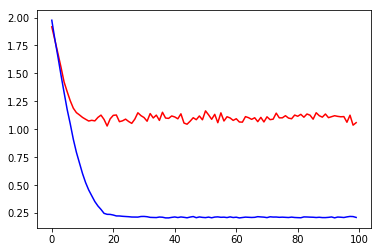

In [19]:
main()

In [41]:
hparams.num_epochs = 100
hparams.batch_size = 6
hparams.learning_rate = 3*1e-5
hparams.momentum = 0.8
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.8143] [Train Acc: 0.4365] [Valid Loss: 1.8471] [Valid Acc: 0.3667]
[Epoch 20/100] [Train Loss: 1.5373] [Train Acc: 0.5470] [Valid Loss: 1.6240] [Valid Acc: 0.3667]
[Epoch 30/100] [Train Loss: 1.2828] [Train Acc: 0.6380] [Valid Loss: 1.4403] [Valid Acc: 0.4600]
Epoch    39: reducing learning rate of group 0 to 6.0000e-06.
[Epoch 40/100] [Train Loss: 1.0235] [Train Acc: 0.7535] [Valid Loss: 1.3162] [Valid Acc: 0.5067]
[Epoch 50/100] [Train Loss: 0.9705] [Train Acc: 0.7654] [Valid Loss: 1.2477] [Valid Acc: 0.5533]
[Epoch 60/100] [Train Loss: 0.9356] [Train Acc: 0.7762] [Valid Loss: 1.2639] [Valid Acc: 0.5133]
Epoch    63: reducing learning rate of group 0 to 1.2000e-06.
[Epoch 70/100] [Train Loss: 0.9194] [Train Acc: 0.7805] [Valid Loss: 1.2463] [Valid Acc: 0.5333]
Epoch    70: reducing learning rate of group 0 to 2.4000e-07.
Epoch    78: reducing learning rate of group 0 to 4.8000e-08.
[Epoch 80/100] [Train Loss: 0.8934] [Train Acc: 0.7918]

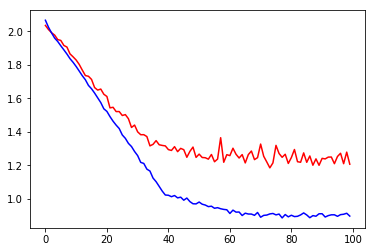

In [42]:
main()

In [43]:
hparams.num_epochs = 100
hparams.batch_size = 12
hparams.learning_rate = 3*1e-5
hparams.momentum = 0.8
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.8697] [Train Acc: 0.3969] [Valid Loss: 1.8659] [Valid Acc: 0.3667]
[Epoch 20/100] [Train Loss: 1.7028] [Train Acc: 0.5113] [Valid Loss: 1.7197] [Valid Acc: 0.4067]
[Epoch 30/100] [Train Loss: 1.5309] [Train Acc: 0.5762] [Valid Loss: 1.5863] [Valid Acc: 0.4467]
[Epoch 40/100] [Train Loss: 1.3678] [Train Acc: 0.6269] [Valid Loss: 1.4682] [Valid Acc: 0.5000]
[Epoch 50/100] [Train Loss: 1.1997] [Train Acc: 0.7023] [Valid Loss: 1.3705] [Valid Acc: 0.5000]
[Epoch 60/100] [Train Loss: 1.0508] [Train Acc: 0.7516] [Valid Loss: 1.3074] [Valid Acc: 0.5067]
[Epoch 70/100] [Train Loss: 0.9092] [Train Acc: 0.8045] [Valid Loss: 1.2508] [Valid Acc: 0.5400]
[Epoch 80/100] [Train Loss: 0.7686] [Train Acc: 0.8445] [Valid Loss: 1.1854] [Valid Acc: 0.5400]
Epoch    87: reducing learning rate of group 0 to 6.0000e-06.
[Epoch 90/100] [Train Loss: 0.6561] [Train Acc: 0.8739] [Valid Loss: 1.1545] [Valid Acc: 0.5933]
Epoch    95: reducing learning rate of group 0 

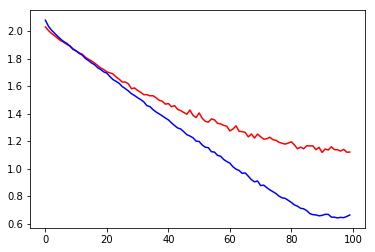

In [44]:
main()

In [47]:
hparams.num_epochs = 100
hparams.batch_size = 6
hparams.learning_rate = 8*1e-5
hparams.momentum = 0.8
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 4.

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.4295] [Train Acc: 0.6020] [Valid Loss: 1.5256] [Valid Acc: 0.4333]
[Epoch 20/100] [Train Loss: 0.7712] [Train Acc: 0.8221] [Valid Loss: 1.1755] [Valid Acc: 0.5867]
[Epoch 30/100] [Train Loss: 0.3997] [Train Acc: 0.9173] [Valid Loss: 1.0376] [Valid Acc: 0.6067]
Epoch    30: reducing learning rate of group 0 to 1.6000e-05.
Epoch    35: reducing learning rate of group 0 to 3.2000e-06.
[Epoch 40/100] [Train Loss: 0.3508] [Train Acc: 0.9218] [Valid Loss: 1.0165] [Valid Acc: 0.6267]
Epoch    42: reducing learning rate of group 0 to 6.4000e-07.
[Epoch 50/100] [Train Loss: 0.3389] [Train Acc: 0.9280] [Valid Loss: 1.0414] [Valid Acc: 0.6000]
Epoch    51: reducing learning rate of group 0 to 1.2800e-07.
Epoch    56: reducing learning rate of group 0 to 2.5600e-08.
[Epoch 60/100] [Train Loss: 0.3368] [Train Acc: 0.9329] [Valid Loss: 1.0829] [Valid Acc: 0.5733]
Epoch    61: reducing learning rate of group 0 to 5.1200e-09.
[Epoch 70/100] [Train Loss: 

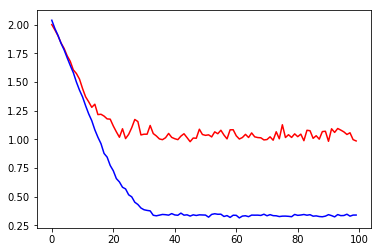

In [48]:
main()

In [51]:
hparams.num_epochs = 100
hparams.batch_size = 6
hparams.learning_rate = 8*1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 4.

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.8023] [Train Acc: 0.7884] [Valid Loss: 1.2386] [Valid Acc: 0.5467]
[Epoch 20/100] [Train Loss: 0.2854] [Train Acc: 0.9280] [Valid Loss: 1.0842] [Valid Acc: 0.5933]
Epoch    27: reducing learning rate of group 0 to 1.6000e-05.
[Epoch 30/100] [Train Loss: 0.1316] [Train Acc: 0.9728] [Valid Loss: 1.1634] [Valid Acc: 0.6333]
Epoch    32: reducing learning rate of group 0 to 3.2000e-06.
Epoch    37: reducing learning rate of group 0 to 6.4000e-07.
[Epoch 40/100] [Train Loss: 0.1231] [Train Acc: 0.9737] [Valid Loss: 1.1728] [Valid Acc: 0.6400]
Epoch    42: reducing learning rate of group 0 to 1.2800e-07.
Epoch    47: reducing learning rate of group 0 to 2.5600e-08.
[Epoch 50/100] [Train Loss: 0.1151] [Train Acc: 0.9765] [Valid Loss: 1.1365] [Valid Acc: 0.6467]
Epoch    52: reducing learning rate of group 0 to 5.1200e-09.
[Epoch 60/100] [Train Loss: 0.1216] [Train Acc: 0.9768] [Valid Loss: 1.1569] [Valid Acc: 0.6467]
[Epoch 70/100] [Train Loss: 

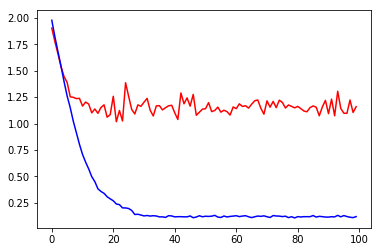

In [52]:
main()

In [55]:
hparams.num_epochs = 100
hparams.batch_size = 6
hparams.learning_rate = 8*1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 2.5

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.8328] [Train Acc: 0.7921] [Valid Loss: 1.0510] [Valid Acc: 0.6200]
[Epoch 20/100] [Train Loss: 0.3147] [Train Acc: 0.9229] [Valid Loss: 0.9409] [Valid Acc: 0.6733]
Epoch    22: reducing learning rate of group 0 to 1.6000e-05.
Epoch    25: reducing learning rate of group 0 to 3.2000e-06.
Epoch    28: reducing learning rate of group 0 to 6.4000e-07.
[Epoch 30/100] [Train Loss: 0.1871] [Train Acc: 0.9663] [Valid Loss: 0.9651] [Valid Acc: 0.6400]
Epoch    31: reducing learning rate of group 0 to 1.2800e-07.
Epoch    34: reducing learning rate of group 0 to 2.5600e-08.
Epoch    37: reducing learning rate of group 0 to 5.1200e-09.
[Epoch 40/100] [Train Loss: 0.1950] [Train Acc: 0.9601] [Valid Loss: 0.9473] [Valid Acc: 0.6400]
[Epoch 50/100] [Train Loss: 0.1967] [Train Acc: 0.9601] [Valid Loss: 0.9037] [Valid Acc: 0.6733]
[Epoch 60/100] [Train Loss: 0.1961] [Train Acc: 0.9595] [Valid Loss: 0.9106] [Valid Acc: 0.6533]
[Epoch 70/100] [Train Loss: 

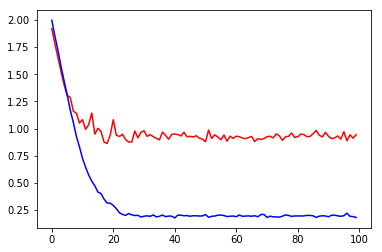

In [56]:
main()

In [57]:
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*3, 117),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)+x1 #Resnet1
        x = self.conv2_1(x)+self.conv2_2(x)
        x = self.conv3(x)
        x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.4295] [Train Acc: 0.8782] [Valid Loss: 1.0554] [Valid Acc: 0.6333]
Epoch    15: reducing learning rate of group 0 to 1.6000e-05.
Epoch    18: reducing learning rate of group 0 to 3.2000e-06.
[Epoch 20/100] [Train Loss: 0.1860] [Train Acc: 0.9575] [Valid Loss: 1.0014] [Valid Acc: 0.6733]
Epoch    21: reducing learning rate of group 0 to 6.4000e-07.
Epoch    24: reducing learning rate of group 0 to 1.2800e-07.
Epoch    27: reducing learning rate of group 0 to 2.5600e-08.
[Epoch 30/100] [Train Loss: 0.1782] [Train Acc: 0.9575] [Valid Loss: 1.0459] [Valid Acc: 0.6733]
Epoch    30: reducing learning rate of group 0 to 5.1200e-09.
[Epoch 40/100] [Train Loss: 0.1781] [Train Acc: 0.9569] [Valid Loss: 1.0418] [Valid Acc: 0.6800]
[Epoch 50/100] [Train Loss: 0.1887] [Train Acc: 0.9470] [Valid Loss: 0.9756] [Valid Acc: 0.7133]
[Epoch 60/100] [Train Loss: 0.1714] [Train Acc: 0.9589] [Valid Loss: 0.9886] [Valid Acc: 0.6933]
[Epoch 70/100] [Train Loss: 

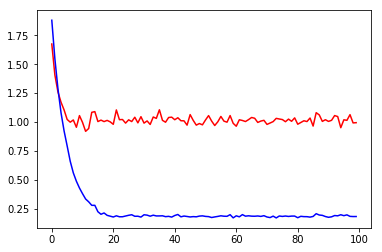

In [58]:
main()

In [59]:
hparams.num_epochs = 100
hparams.batch_size = 6
hparams.learning_rate = 3*1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 2.5

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.0010] [Train Acc: 0.6881] [Valid Loss: 1.1677] [Valid Acc: 0.5733]
Epoch    18: reducing learning rate of group 0 to 6.0000e-06.
[Epoch 20/100] [Train Loss: 0.5425] [Train Acc: 0.8521] [Valid Loss: 1.0983] [Valid Acc: 0.6267]
Epoch    21: reducing learning rate of group 0 to 1.2000e-06.
[Epoch 30/100] [Train Loss: 0.5201] [Train Acc: 0.8527] [Valid Loss: 1.0990] [Valid Acc: 0.6200]
Epoch    34: reducing learning rate of group 0 to 2.4000e-07.
Epoch    37: reducing learning rate of group 0 to 4.8000e-08.
[Epoch 40/100] [Train Loss: 0.5173] [Train Acc: 0.8538] [Valid Loss: 1.0466] [Valid Acc: 0.6200]
Epoch    40: reducing learning rate of group 0 to 9.6000e-09.
[Epoch 50/100] [Train Loss: 0.5011] [Train Acc: 0.8686] [Valid Loss: 1.0838] [Valid Acc: 0.6267]
[Epoch 60/100] [Train Loss: 0.5049] [Train Acc: 0.8592] [Valid Loss: 1.1171] [Valid Acc: 0.6267]
[Epoch 70/100] [Train Loss: 0.5018] [Train Acc: 0.8697] [Valid Loss: 1.0650] [Valid Acc: 0

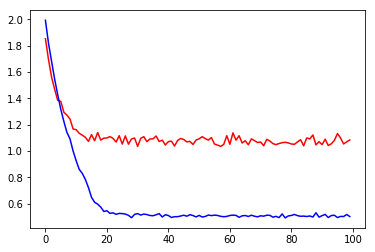

In [60]:
main()

In [61]:
hparams.num_epochs = 100
hparams.batch_size = 6
hparams.learning_rate = 1e-4
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 2.

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.3458] [Train Acc: 0.9031] [Valid Loss: 1.0069] [Valid Acc: 0.6667]
Epoch    11: reducing learning rate of group 0 to 2.0000e-05.
Epoch    14: reducing learning rate of group 0 to 4.0000e-06.
Epoch    17: reducing learning rate of group 0 to 8.0000e-07.
[Epoch 20/100] [Train Loss: 0.2206] [Train Acc: 0.9436] [Valid Loss: 0.9329] [Valid Acc: 0.6467]
Epoch    21: reducing learning rate of group 0 to 1.6000e-07.
Epoch    25: reducing learning rate of group 0 to 3.2000e-08.
[Epoch 30/100] [Train Loss: 0.2161] [Train Acc: 0.9433] [Valid Loss: 0.9080] [Valid Acc: 0.6600]
Epoch    31: reducing learning rate of group 0 to 6.4000e-09.
[Epoch 40/100] [Train Loss: 0.2060] [Train Acc: 0.9484] [Valid Loss: 0.9441] [Valid Acc: 0.6400]
[Epoch 50/100] [Train Loss: 0.2262] [Train Acc: 0.9368] [Valid Loss: 0.9482] [Valid Acc: 0.6400]
[Epoch 60/100] [Train Loss: 0.2132] [Train Acc: 0.9496] [Valid Loss: 0.9215] [Valid Acc: 0.6533]
[Epoch 70/100] [Train Loss: 

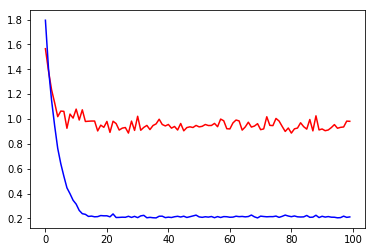

In [62]:
main()

In [63]:
hparams.num_epochs = 100
hparams.batch_size = 6
hparams.learning_rate = 8*1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 2.

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.4508] [Train Acc: 0.8771] [Valid Loss: 0.9129] [Valid Acc: 0.6933]
Epoch    14: reducing learning rate of group 0 to 1.6000e-05.
Epoch    17: reducing learning rate of group 0 to 3.2000e-06.
[Epoch 20/100] [Train Loss: 0.2095] [Train Acc: 0.9484] [Valid Loss: 0.9543] [Valid Acc: 0.6600]
Epoch    20: reducing learning rate of group 0 to 6.4000e-07.
Epoch    23: reducing learning rate of group 0 to 1.2800e-07.
Epoch    26: reducing learning rate of group 0 to 2.5600e-08.
Epoch    29: reducing learning rate of group 0 to 5.1200e-09.
[Epoch 30/100] [Train Loss: 0.2059] [Train Acc: 0.9462] [Valid Loss: 0.9270] [Valid Acc: 0.6733]
[Epoch 40/100] [Train Loss: 0.2266] [Train Acc: 0.9422] [Valid Loss: 0.9122] [Valid Acc: 0.7000]
[Epoch 50/100] [Train Loss: 0.2154] [Train Acc: 0.9453] [Valid Loss: 0.9844] [Valid Acc: 0.6600]
[Epoch 60/100] [Train Loss: 0.2159] [Train Acc: 0.9470] [Valid Loss: 0.9335] [Valid Acc: 0.6800]
[Epoch 70/100] [Train Loss: 

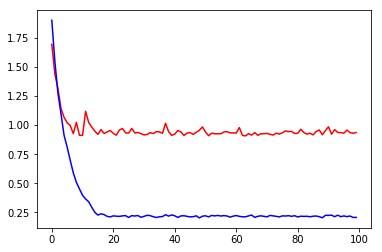

In [64]:
main()

In [65]:

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*3, 117),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)+x1 #Resnet1
        x = self.conv2_1(x)+self.conv2_2(x)
        x = self.conv3(x)
        #x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.6091] [Train Acc: 0.8317] [Valid Loss: 1.2542] [Valid Acc: 0.5267]
Epoch    10: reducing learning rate of group 0 to 1.6000e-05.
Epoch    15: reducing learning rate of group 0 to 3.2000e-06.
Epoch    19: reducing learning rate of group 0 to 6.4000e-07.
[Epoch 20/100] [Train Loss: 0.4285] [Train Acc: 0.8969] [Valid Loss: 1.0686] [Valid Acc: 0.6000]
Epoch    24: reducing learning rate of group 0 to 1.2800e-07.
Epoch    27: reducing learning rate of group 0 to 2.5600e-08.
[Epoch 30/100] [Train Loss: 0.4146] [Train Acc: 0.9025] [Valid Loss: 1.0158] [Valid Acc: 0.6400]
Epoch    30: reducing learning rate of group 0 to 5.1200e-09.
[Epoch 40/100] [Train Loss: 0.4135] [Train Acc: 0.8980] [Valid Loss: 1.0377] [Valid Acc: 0.6267]
[Epoch 50/100] [Train Loss: 0.4205] [Train Acc: 0.9037] [Valid Loss: 1.0058] [Valid Acc: 0.6467]
[Epoch 60/100] [Train Loss: 0.4001] [Train Acc: 0.9110] [Valid Loss: 1.0188] [Valid Acc: 0.6400]
[Epoch 70/100] [Train Loss: 

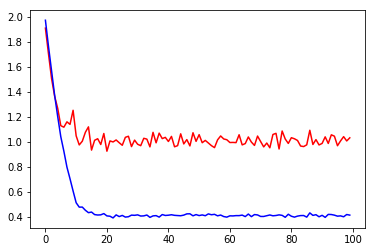

In [66]:
main()

In [67]:
hparams.num_epochs = 100
hparams.batch_size = 6
hparams.learning_rate = 4*1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 2.

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.1653] [Train Acc: 0.6414] [Valid Loss: 1.3035] [Valid Acc: 0.4800]
[Epoch 20/100] [Train Loss: 0.5667] [Train Acc: 0.8564] [Valid Loss: 1.0863] [Valid Acc: 0.6067]
Epoch    25: reducing learning rate of group 0 to 8.0000e-06.
Epoch    28: reducing learning rate of group 0 to 1.6000e-06.
[Epoch 30/100] [Train Loss: 0.3469] [Train Acc: 0.9249] [Valid Loss: 1.0391] [Valid Acc: 0.6267]
Epoch    34: reducing learning rate of group 0 to 3.2000e-07.
[Epoch 40/100] [Train Loss: 0.3240] [Train Acc: 0.9258] [Valid Loss: 1.0208] [Valid Acc: 0.6133]
Epoch    42: reducing learning rate of group 0 to 6.4000e-08.
Epoch    45: reducing learning rate of group 0 to 1.2800e-08.
Epoch    48: reducing learning rate of group 0 to 2.5600e-09.
[Epoch 50/100] [Train Loss: 0.3294] [Train Acc: 0.9266] [Valid Loss: 1.1034] [Valid Acc: 0.6000]
[Epoch 60/100] [Train Loss: 0.3346] [Train Acc: 0.9255] [Valid Loss: 1.0470] [Valid Acc: 0.6200]
[Epoch 70/100] [Train Loss: 

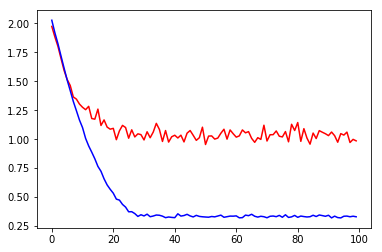

In [68]:
main()

In [69]:

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 256, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*3, 117),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = self.conv2_1(x)
        x = self.conv3(x)
        #x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.2002] [Train Acc: 0.6105] [Valid Loss: 1.6307] [Valid Acc: 0.3600]
Epoch    16: reducing learning rate of group 0 to 8.0000e-06.
Epoch    19: reducing learning rate of group 0 to 1.6000e-06.
[Epoch 20/100] [Train Loss: 0.7707] [Train Acc: 0.7722] [Valid Loss: 1.5151] [Valid Acc: 0.4000]
Epoch    29: reducing learning rate of group 0 to 3.2000e-07.
[Epoch 30/100] [Train Loss: 0.7450] [Train Acc: 0.7796] [Valid Loss: 1.4536] [Valid Acc: 0.4267]
Epoch    32: reducing learning rate of group 0 to 6.4000e-08.
Epoch    35: reducing learning rate of group 0 to 1.2800e-08.
Epoch    38: reducing learning rate of group 0 to 2.5600e-09.
[Epoch 40/100] [Train Loss: 0.7528] [Train Acc: 0.7745] [Valid Loss: 1.4166] [Valid Acc: 0.4467]
[Epoch 50/100] [Train Loss: 0.7604] [Train Acc: 0.7790] [Valid Loss: 1.5128] [Valid Acc: 0.4000]
[Epoch 60/100] [Train Loss: 0.7423] [Train Acc: 0.7898] [Valid Loss: 1.5118] [Valid Acc: 0.4000]
[Epoch 70/100] [Train Loss: 

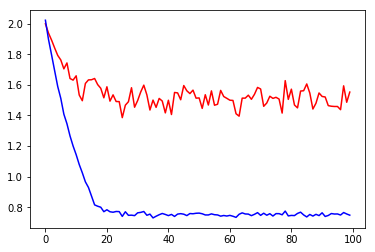

In [71]:
main()

In [5]:

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*14, 117),
        nn.Dropout(p=0.4, inplace=False),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)+x1 #Resnet1
        x = self.conv2_1(x)+self.conv2_2(x)
        #x = self.conv3(x)
        #x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.0724] [Train Acc: 0.6467] [Valid Loss: 1.1061] [Valid Acc: 0.6133]
[Epoch 20/100] [Train Loss: 0.6064] [Train Acc: 0.8057] [Valid Loss: 0.9903] [Valid Acc: 0.6600]
Epoch    27: reducing learning rate of group 0 to 8.0000e-06.
[Epoch 30/100] [Train Loss: 0.3950] [Train Acc: 0.8870] [Valid Loss: 1.0075] [Valid Acc: 0.6533]
Epoch    30: reducing learning rate of group 0 to 1.6000e-06.
Epoch    33: reducing learning rate of group 0 to 3.2000e-07.
Epoch    36: reducing learning rate of group 0 to 6.4000e-08.
Epoch    39: reducing learning rate of group 0 to 1.2800e-08.
[Epoch 40/100] [Train Loss: 0.3710] [Train Acc: 0.8907] [Valid Loss: 0.9425] [Valid Acc: 0.6667]
Epoch    43: reducing learning rate of group 0 to 2.5600e-09.
[Epoch 50/100] [Train Loss: 0.3986] [Train Acc: 0.8742] [Valid Loss: 0.9885] [Valid Acc: 0.6533]
[Epoch 60/100] [Train Loss: 0.3736] [Train Acc: 0.8898] [Valid Loss: 1.0251] [Valid Acc: 0.6467]
[Epoch 70/100] [Train Loss: 

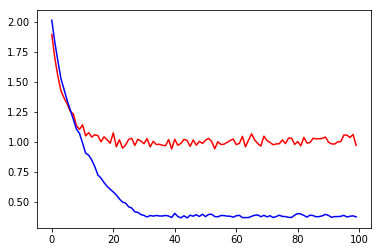

In [75]:
main()

In [7]:
hparams.num_epochs = 100
hparams.batch_size = 6
hparams.learning_rate = 1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 2.

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.6560] [Train Acc: 0.3816] [Valid Loss: 1.5757] [Valid Acc: 0.4133]
[Epoch 20/100] [Train Loss: 1.3340] [Train Acc: 0.5297] [Valid Loss: 1.3056] [Valid Acc: 0.5200]
[Epoch 30/100] [Train Loss: 1.0957] [Train Acc: 0.6238] [Valid Loss: 1.1540] [Valid Acc: 0.5667]
[Epoch 40/100] [Train Loss: 0.9168] [Train Acc: 0.6895] [Valid Loss: 1.0860] [Valid Acc: 0.5933]
Epoch    44: reducing learning rate of group 0 to 2.0000e-06.
[Epoch 50/100] [Train Loss: 0.8625] [Train Acc: 0.7037] [Valid Loss: 1.0739] [Valid Acc: 0.6333]
Epoch    55: reducing learning rate of group 0 to 4.0000e-07.
Epoch    58: reducing learning rate of group 0 to 8.0000e-08.
[Epoch 60/100] [Train Loss: 0.8579] [Train Acc: 0.7105] [Valid Loss: 1.0990] [Valid Acc: 0.5933]
Epoch    61: reducing learning rate of group 0 to 1.6000e-08.
Epoch    64: reducing learning rate of group 0 to 3.2000e-09.
[Epoch 70/100] [Train Loss: 0.8396] [Train Acc: 0.7144] [Valid Loss: 1.0386] [Valid Acc: 0

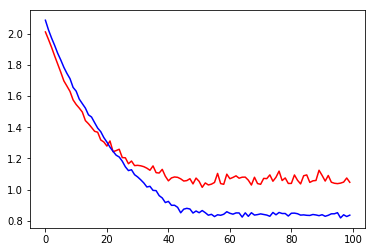

In [8]:
main()

In [9]:
hparams.num_epochs = 100
hparams.batch_size = 6
hparams.learning_rate = 4*1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 2.

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.9863] [Train Acc: 0.6649] [Valid Loss: 1.1419] [Valid Acc: 0.5467]
[Epoch 20/100] [Train Loss: 0.5921] [Train Acc: 0.8139] [Valid Loss: 1.0014] [Valid Acc: 0.6267]
Epoch    24: reducing learning rate of group 0 to 8.0000e-06.
Epoch    28: reducing learning rate of group 0 to 1.6000e-06.
[Epoch 30/100] [Train Loss: 0.4272] [Train Acc: 0.8722] [Valid Loss: 0.9408] [Valid Acc: 0.6600]
Epoch    32: reducing learning rate of group 0 to 3.2000e-07.
Epoch    37: reducing learning rate of group 0 to 6.4000e-08.
[Epoch 40/100] [Train Loss: 0.4018] [Train Acc: 0.8748] [Valid Loss: 0.9068] [Valid Acc: 0.6867]
Epoch    40: reducing learning rate of group 0 to 1.2800e-08.
Epoch    43: reducing learning rate of group 0 to 2.5600e-09.
[Epoch 50/100] [Train Loss: 0.3922] [Train Acc: 0.8796] [Valid Loss: 1.0490] [Valid Acc: 0.6267]
[Epoch 60/100] [Train Loss: 0.4080] [Train Acc: 0.8748] [Valid Loss: 0.9243] [Valid Acc: 0.6800]
[Epoch 70/100] [Train Loss: 

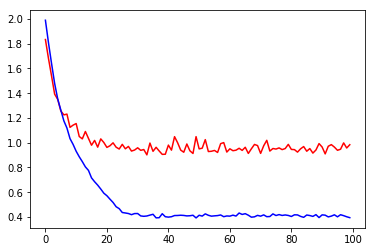

In [10]:
main()

In [77]:
hparams.num_epochs = 100
hparams.batch_size = 6
hparams.learning_rate = 5*1e-6
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.8654] [Train Acc: 0.3037] [Valid Loss: 1.8277] [Valid Acc: 0.3267]
[Epoch 20/100] [Train Loss: 1.6855] [Train Acc: 0.3830] [Valid Loss: 1.6483] [Valid Acc: 0.3800]
[Epoch 30/100] [Train Loss: 1.5252] [Train Acc: 0.4385] [Valid Loss: 1.4997] [Valid Acc: 0.4333]
[Epoch 40/100] [Train Loss: 1.3836] [Train Acc: 0.5176] [Valid Loss: 1.3812] [Valid Acc: 0.4400]
[Epoch 50/100] [Train Loss: 1.2429] [Train Acc: 0.5680] [Valid Loss: 1.2917] [Valid Acc: 0.5467]
[Epoch 60/100] [Train Loss: 1.1396] [Train Acc: 0.6065] [Valid Loss: 1.2201] [Valid Acc: 0.5733]
[Epoch 70/100] [Train Loss: 1.0210] [Train Acc: 0.6462] [Valid Loss: 1.1477] [Valid Acc: 0.6000]
Epoch    74: reducing learning rate of group 0 to 1.0000e-06.
Epoch    79: reducing learning rate of group 0 to 2.0000e-07.
[Epoch 80/100] [Train Loss: 0.9813] [Train Acc: 0.6663] [Valid Loss: 1.1555] [Valid Acc: 0.5667]
Epoch    83: reducing learning rate of group 0 to 4.0000e-08.
[Epoch 90/100] [Trai

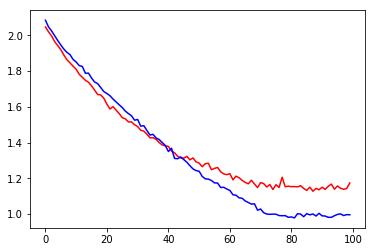

In [78]:
main()

In [6]:
hparams.num_epochs = 100
hparams.batch_size = 6
hparams.learning_rate = 8*1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 2.5

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.6508] [Train Acc: 0.7912] [Valid Loss: 1.0441] [Valid Acc: 0.6400]
Epoch    13: reducing learning rate of group 0 to 1.6000e-05.
Epoch    17: reducing learning rate of group 0 to 3.2000e-06.
[Epoch 20/100] [Train Loss: 0.3942] [Train Acc: 0.8810] [Valid Loss: 1.0262] [Valid Acc: 0.6600]
Epoch    20: reducing learning rate of group 0 to 6.4000e-07.
Epoch    23: reducing learning rate of group 0 to 1.2800e-07.
Epoch    26: reducing learning rate of group 0 to 2.5600e-08.
Epoch    29: reducing learning rate of group 0 to 5.1200e-09.
[Epoch 30/100] [Train Loss: 0.4028] [Train Acc: 0.8776] [Valid Loss: 1.0289] [Valid Acc: 0.6667]
[Epoch 40/100] [Train Loss: 0.3983] [Train Acc: 0.8728] [Valid Loss: 1.0396] [Valid Acc: 0.6533]
[Epoch 50/100] [Train Loss: 0.3924] [Train Acc: 0.8734] [Valid Loss: 1.0389] [Valid Acc: 0.6467]
[Epoch 60/100] [Train Loss: 0.3810] [Train Acc: 0.8873] [Valid Loss: 1.0527] [Valid Acc: 0.6667]
[Epoch 70/100] [Train Loss: 

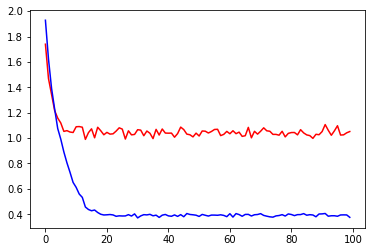

In [7]:
main()

In [8]:
hparams.learning_rate = 5*1e-5
hparams.patience = 3.

Training on GPU:0
[Epoch 10/100] [Train Loss: 0.9419] [Train Acc: 0.6751] [Valid Loss: 1.1108] [Valid Acc: 0.5667]
[Epoch 20/100] [Train Loss: 0.5160] [Train Acc: 0.8360] [Valid Loss: 0.9156] [Valid Acc: 0.6800]
Epoch    24: reducing learning rate of group 0 to 1.0000e-05.
Epoch    28: reducing learning rate of group 0 to 2.0000e-06.
[Epoch 30/100] [Train Loss: 0.3360] [Train Acc: 0.9071] [Valid Loss: 0.9741] [Valid Acc: 0.6600]
Epoch    32: reducing learning rate of group 0 to 4.0000e-07.
Epoch    36: reducing learning rate of group 0 to 8.0000e-08.
[Epoch 40/100] [Train Loss: 0.3436] [Train Acc: 0.9008] [Valid Loss: 0.9558] [Valid Acc: 0.6533]
Epoch    40: reducing learning rate of group 0 to 1.6000e-08.
Epoch    44: reducing learning rate of group 0 to 3.2000e-09.
[Epoch 50/100] [Train Loss: 0.3308] [Train Acc: 0.9045] [Valid Loss: 1.0188] [Valid Acc: 0.6533]
[Epoch 60/100] [Train Loss: 0.3419] [Train Acc: 0.8929] [Valid Loss: 0.9506] [Valid Acc: 0.6667]
[Epoch 70/100] [Train Loss: 

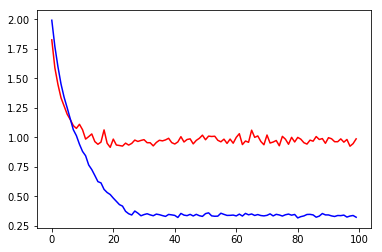

In [9]:
main()

In [10]:

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*14, 117),
        nn.Dropout(p=0.4, inplace=False),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)+x1 #Resnet1
        x = self.conv2_2(x)
        #x = self.conv3(x)
        #x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.1123] [Train Acc: 0.6258] [Valid Loss: 1.1242] [Valid Acc: 0.5667]
[Epoch 20/100] [Train Loss: 0.6767] [Train Acc: 0.7929] [Valid Loss: 0.8570] [Valid Acc: 0.6933]
Epoch    26: reducing learning rate of group 0 to 1.0000e-05.
[Epoch 30/100] [Train Loss: 0.4713] [Train Acc: 0.8683] [Valid Loss: 0.9281] [Valid Acc: 0.6800]
Epoch    30: reducing learning rate of group 0 to 2.0000e-06.
Epoch    34: reducing learning rate of group 0 to 4.0000e-07.
Epoch    38: reducing learning rate of group 0 to 8.0000e-08.
[Epoch 40/100] [Train Loss: 0.4467] [Train Acc: 0.8663] [Valid Loss: 0.8703] [Valid Acc: 0.6933]
Epoch    42: reducing learning rate of group 0 to 1.6000e-08.
Epoch    46: reducing learning rate of group 0 to 3.2000e-09.
[Epoch 50/100] [Train Loss: 0.4384] [Train Acc: 0.8779] [Valid Loss: 0.9564] [Valid Acc: 0.6800]
[Epoch 60/100] [Train Loss: 0.4527] [Train Acc: 0.8759] [Valid Loss: 0.9049] [Valid Acc: 0.7000]
[Epoch 70/100] [Train Loss: 

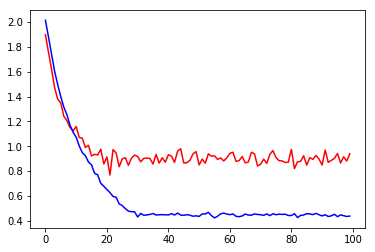

In [11]:
main()

In [5]:

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*14, 117),
        nn.Dropout(p=0.4, inplace=False),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = self.conv2_2(x)
        #x = self.conv3(x)
        #x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

Training on GPU:0
[Epoch 10/100] [Train Loss: 1.1124] [Train Acc: 0.6224] [Valid Loss: 1.2918] [Valid Acc: 0.4733]
[Epoch 20/100] [Train Loss: 0.7447] [Train Acc: 0.7643] [Valid Loss: 1.3615] [Valid Acc: 0.4800]
Epoch    26: reducing learning rate of group 0 to 1.0000e-05.
[Epoch 30/100] [Train Loss: 0.5375] [Train Acc: 0.8360] [Valid Loss: 1.0669] [Valid Acc: 0.6400]
Epoch    34: reducing learning rate of group 0 to 2.0000e-06.
Epoch    38: reducing learning rate of group 0 to 4.0000e-07.
[Epoch 40/100] [Train Loss: 0.4870] [Train Acc: 0.8677] [Valid Loss: 1.2402] [Valid Acc: 0.5867]
Epoch    42: reducing learning rate of group 0 to 8.0000e-08.
Epoch    46: reducing learning rate of group 0 to 1.6000e-08.
[Epoch 50/100] [Train Loss: 0.4988] [Train Acc: 0.8524] [Valid Loss: 1.2233] [Valid Acc: 0.5733]
Epoch    50: reducing learning rate of group 0 to 3.2000e-09.
[Epoch 60/100] [Train Loss: 0.4916] [Train Acc: 0.8516] [Valid Loss: 1.2475] [Valid Acc: 0.5867]
[Epoch 70/100] [Train Loss: 

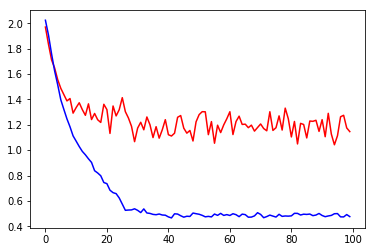

In [13]:
main()

In [6]:
main()

MemoryError: 

In [7]:
hparams.num_epochs = 100
hparams.batch_size = 10
hparams.learning_rate = 1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

In [ ]:
main()

In [ ]:
hparams.num_epochs = 100
hparams.batch_size = 10
hparams.learning_rate = 2*1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

In [ ]:
main()

In [ ]:
hparams.num_epochs = 100
hparams.batch_size = 10
hparams.learning_rate = 4*1e-5
hparams.momentum = 0.9
hparams.factor = 0.2
hparams.weight_decay = 1e-6
hparams.patience = 3.

In [ ]:
main()

In [ ]:

class Baseline(nn.Module):
    def __init__(self, hparams):
        super(Baseline, self).__init__()
        
        self.conv0 = nn.Sequential(
        nn.Conv1d(hparams.num_mels, 64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )

        self.conv1 = nn.Sequential(
        nn.Conv1d(64, 128, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        nn.MaxPool1d(4, stride=4)
        
        )
        #Res 1
        self.block0 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=4, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(16, stride=16)
        )

        #분할하여 다르게 처리
        self.conv2_1 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.Dropout(p=0.3, inplace=False),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        self.conv2_2 = nn.Sequential(
        nn.Conv1d(128, 128, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.AvgPool1d(4, stride=4)
        )
        
        
         
        self.conv3 = nn.Sequential(
        nn.Conv1d(256, 128, kernel_size=4, stride=1, padding=2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(4, stride=4)
        )
        
        
        ## ResNet2
        self.block1 = nn.Sequential(
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8),
        nn.Conv1d(128,128, kernel_size=8, stride=2, padding=1),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.MaxPool1d(8, stride=8)
        )
        

        self.linear0 = nn.Sequential(
        nn.Dropout(p=0.4, inplace=False),
        nn.Linear(128*14, 117),
        nn.Dropout(p=0.4, inplace=False),
        nn.ReLU(),
        nn.Linear(117, len(hparams.genres))
        )
        

    def forward(self, x):

        x0 = x.transpose(1, 2)
        x1 = self.block0(x0)
        x2 = self.block1(x0)
        x = self.conv0(x0)
        x = self.conv1(x)
        x = self.conv2_1(x)
        #x = self.conv3(x)
        #x = x+x2#Resnet 2  
        #x = self.conv4(x)
        x = x.view(x.size(0), x.size(1)*x.size(2))
        x = self.linear0(x)

        return x
    

In [ ]:
main()